In [1]:
from ultralytics.utils.callbacks.base import on_predict_end
# Check GPU type
!nvidia-smi

Sun Dec  1 11:10:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   25C    P8              8W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# Install ultralytics
!pip -q install  ultralytics

In [2]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing


WARNING  Python>=3.10 is required, but Python==3.8.20 is currently installed 


In [3]:
# get data from s3

# Create directories in standard python environment
os.makedirs('./dataset', exist_ok=True)
os.makedirs('./images', exist_ok=True)
os.makedirs('./data', exist_ok=True)

# download the data
!aws s3 cp s3://crop-diseases/images.zip ./data
!aws s3 cp s3://crop-diseases/Train.csv ./data
!aws s3 cp s3://crop-diseases/Test.csv ./data
!aws s3 cp s3://crop-diseases/SampleSubmission.csv ./data


Completed 256.0 KiB/10.4 GiB (69.5 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/10.4 GiB (135.9 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/10.4 GiB (203.6 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/10.4 GiB (265.0 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/10.4 GiB (330.2 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/10.4 GiB (390.8 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/10.4 GiB (452.6 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/10.4 GiB (516.6 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/10.4 GiB (580.9 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/10.4 GiB (645.2 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/10.4 GiB (709.6 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/10.4 GiB (770.7 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/10.4 GiB (820.5 KiB/s) with 1 file(s) remaining  
Completed 3.5 MiB/10.4 GiB (883.4 KiB/s) with 1 file(s) remaining  
Completed 3.8 MiB/10.4 GiB (944.1 KiB/s) with 1 f

In [4]:
# Set up directories for training a yolo model

DATA_DIR = Path('data')

# Images directories
DATASET_DIR = Path('dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [7]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [5]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax            image_path  class_id  
0   208.107730   341.967928  images\id_11543h.jpg         5  
1   162.910362   266.195724  images\id_11543h.jpg         5  
2   252.712993   338.876645  images\id_11543h.jpg         5  
3   238.593750   354.651316  images\id_11543h.jpg         5  
4  2184.252196  1401.748952  images\id_11ee1c.jpg         8

In [6]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images\id_128pxx.jpg  
1  images\id_12jbci.jpg  
2  images\id_143s4o.jpg  
3  images\id_14tfmb.jpg  
4  images\id_14tw4o.jpg

In [7]:
ss.head()

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

In [11]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [12]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [13]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [14]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [15]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax            image_path  class_id  
0   328.803454  208.107730   341.967928  images/id_11543h.jpg         5  
1   256.768914  162.910362   266.195724  images/id_11543h.jpg         5  
2   327.138158  252.712993   338.876645  images/id_11543h.jpg         5  
3   340.411184  238.593750   354.651316  images/id_11543h.jpg         5  
6  2735.933839  850.476742  2834.348725  images/id_11gglx.jpg         0

In [16]:
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations
def process_dataset(dataframe, output_dir):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use multiprocessing Pool to process tasks
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

100%|██████████| 1226/1226 [00:13<00:00, 93.74it/s] 


In [17]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('dataset/images/train')

In [18]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(TRAIN_IMAGES_DIR),
    'val': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(VAL_IMAGES_DIR),
    'test': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train',
 'val': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val',
 'test': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_11543h.jpg with 4 bounding boxes.


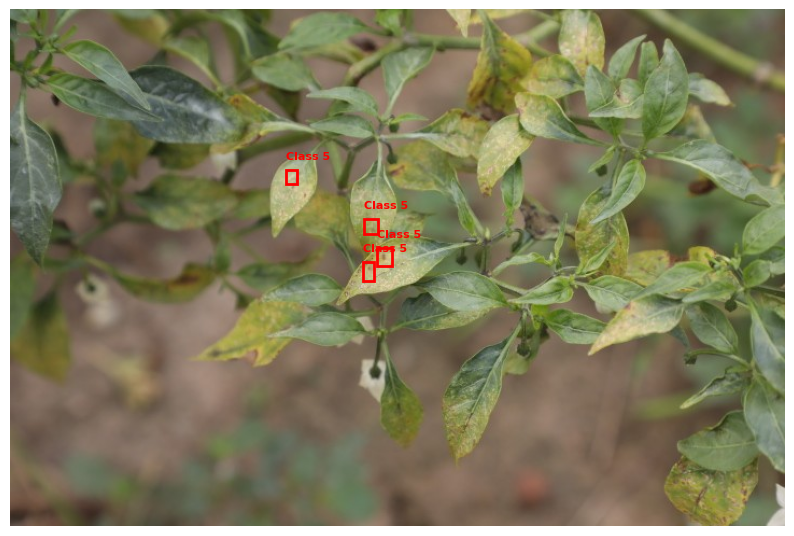

Plotting id_11gglx.jpg with 11 bounding boxes.


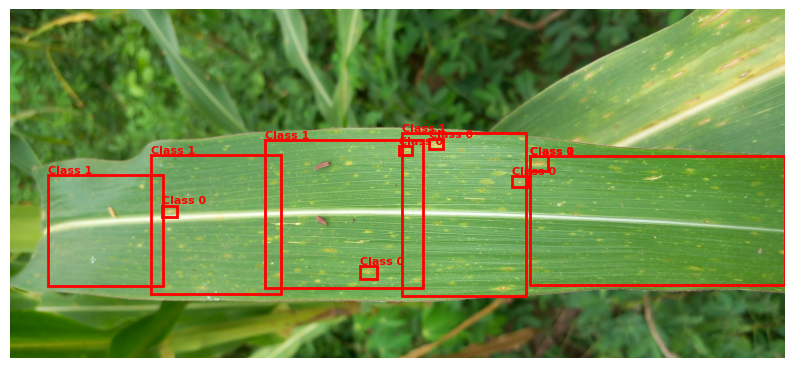

Plotting id_11zffz.jpg with 10 bounding boxes.


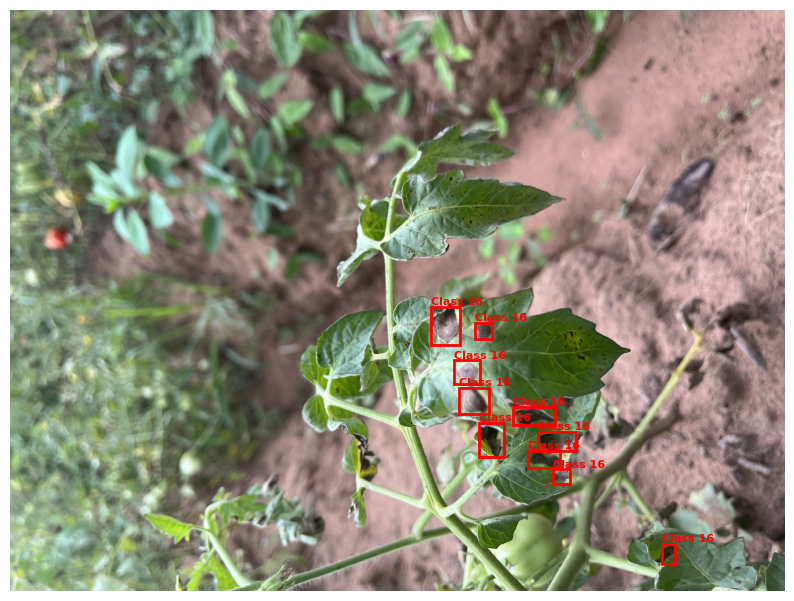

Plotting id_12q33h.jpg with 3 bounding boxes.


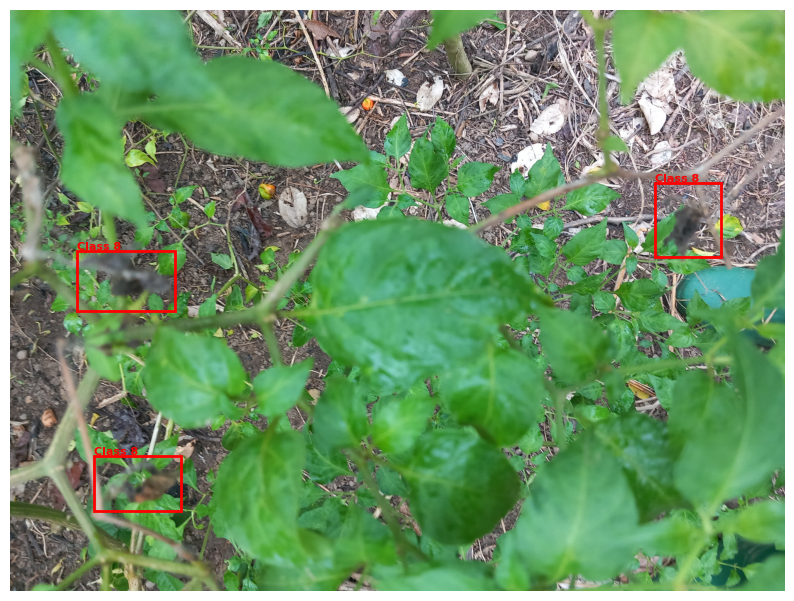

Plotting id_13a6yy.jpg with 2 bounding boxes.


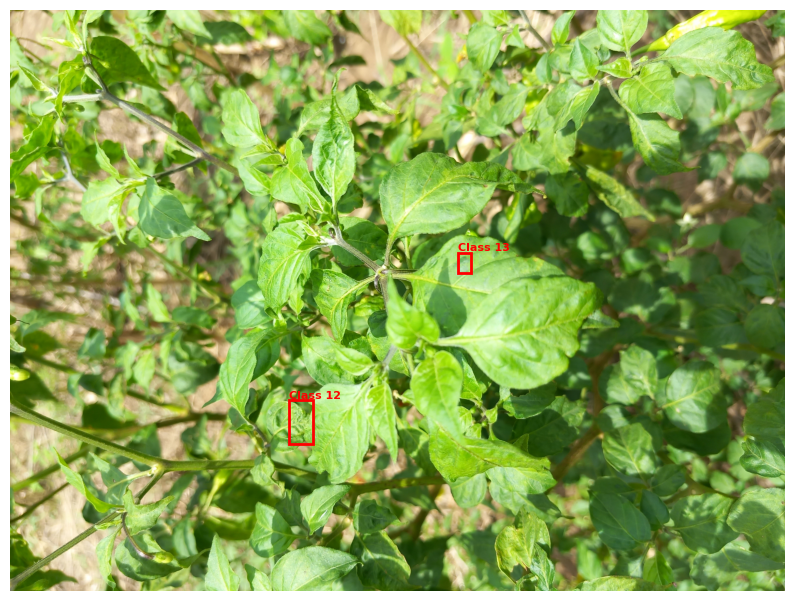

In [19]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [20]:
# Load a yolo pre-trained model

model = YOLO('yolo11n.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=40,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)

Ultralytics 8.3.39 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=40, time=None, patience=5, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

train: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/train.cache... 3676 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3676/3676 [00:00<?, ?it/s]
val: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2024/12/01 11:19:32 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2024/12/01 11:19:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/01 11:19:33 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.5.0, but the installed version is 3.6.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2024/12/01 11:19:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/12/01 11:19:33 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.3, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2024/12/01 11:19:33 INFO mlflow.tr

MLflow: logging run_id(a1e3749fa0f4471bb71c334d619a0d5b) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.35G      2.449      4.762      1.869         32       1024: 100%|██████████| 460/460 [01:29<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  5.96it/s]


                   all       1226      10252       0.59      0.116     0.0632     0.0252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.88G      2.299       3.64      1.688         61       1024: 100%|██████████| 460/460 [01:24<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.11it/s]


                   all       1226      10252      0.462      0.149     0.0935     0.0373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.85G      2.226      3.216      1.658         74       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.17it/s]


                   all       1226      10252      0.364      0.174      0.116     0.0467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.78G      2.187      3.021      1.634         35       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.39it/s]


                   all       1226      10252      0.334      0.181      0.124     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      4.09G      2.169      2.832      1.621         33       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.14it/s]


                   all       1226      10252       0.34      0.243      0.148     0.0632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       4.4G      2.142      2.723      1.609         43       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.28it/s]


                   all       1226      10252      0.376      0.236      0.158     0.0658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.88G      2.111      2.597      1.576         46       1024: 100%|██████████| 460/460 [01:23<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.32it/s]


                   all       1226      10252       0.43      0.257      0.171     0.0733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      4.97G      2.094      2.519      1.572         57       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.34it/s]


                   all       1226      10252      0.403      0.263      0.189     0.0807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.68G      2.094      2.462      1.561         47       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.11it/s]


                   all       1226      10252      0.411      0.276      0.198     0.0848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.89G      2.084      2.407       1.56         32       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.33it/s]


                   all       1226      10252      0.374      0.282      0.213     0.0897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      5.08G      2.061      2.383      1.549         46       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.38it/s]


                   all       1226      10252      0.441      0.263      0.195     0.0819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      5.47G      2.046      2.333      1.545         38       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.45it/s]


                   all       1226      10252      0.403       0.29      0.218     0.0945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.67G      2.034      2.302      1.536         21       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.38it/s]


                   all       1226      10252      0.412      0.296      0.225     0.0961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.43G      2.037      2.271      1.536         71       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.47it/s]


                   all       1226      10252      0.426        0.3      0.234      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.18G      2.015      2.216      1.518         52       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.34it/s]


                   all       1226      10252      0.378      0.307      0.222     0.0997

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      4.75G      2.007      2.202      1.521        117       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.35it/s]


                   all       1226      10252      0.412      0.317      0.234      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       4.7G      2.004      2.165      1.506         31       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.22it/s]


                   all       1226      10252      0.421      0.305       0.25      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      4.53G      2.001      2.161        1.5         32       1024: 100%|██████████| 460/460 [01:23<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.30it/s]


                   all       1226      10252      0.432      0.305      0.251      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      4.52G      1.972      2.113      1.484         86       1024: 100%|██████████| 460/460 [01:23<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.19it/s]


                   all       1226      10252      0.421      0.309      0.252       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       5.5G      1.985      2.109        1.5         40       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.28it/s]


                   all       1226      10252      0.416       0.33      0.265      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      4.57G      1.972      2.078      1.483         55       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.32it/s]


                   all       1226      10252       0.41      0.334      0.268      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      4.87G      1.957      2.038      1.486         32       1024: 100%|██████████| 460/460 [01:23<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.43it/s]


                   all       1226      10252      0.396      0.326      0.264      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      5.51G      1.961      2.021      1.472         28       1024: 100%|██████████| 460/460 [01:23<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.19it/s]


                   all       1226      10252      0.388      0.343      0.274       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      4.58G      1.951      2.008      1.466         23       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.28it/s]


                   all       1226      10252      0.429      0.334      0.281      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40       4.4G      1.953      2.004       1.47         43       1024: 100%|██████████| 460/460 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.40it/s]


                   all       1226      10252      0.468      0.318      0.287      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      4.69G       1.93      1.974      1.459         40       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.54it/s]


                   all       1226      10252      0.426      0.354      0.282      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      4.03G       1.93      1.954      1.453         51       1024: 100%|██████████| 460/460 [01:23<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.45it/s]


                   all       1226      10252      0.449      0.351        0.3      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      4.39G       1.91       1.93      1.446         52       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.35it/s]


                   all       1226      10252      0.396      0.356      0.299      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      4.29G      1.919      1.935      1.453         69       1024: 100%|██████████| 460/460 [01:24<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.48it/s]


                   all       1226      10252      0.441      0.355      0.303      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      4.93G      1.923      1.916      1.439        108       1024: 100%|██████████| 460/460 [01:24<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.49it/s]


                   all       1226      10252      0.443      0.349      0.305      0.137
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      4.26G      1.936      1.947      1.478         31       1024: 100%|██████████| 460/460 [01:22<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.30it/s]


                   all       1226      10252       0.42       0.34      0.296      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      4.22G      1.911       1.89      1.472         15       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.52it/s]


                   all       1226      10252      0.431      0.359      0.309      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      4.38G      1.915      1.882      1.465          7       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.41it/s]


                   all       1226      10252      0.448       0.37      0.315      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      4.72G      1.895      1.845      1.453         20       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.37it/s]


                   all       1226      10252      0.441      0.364      0.314      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.93G      1.888      1.832       1.45         38       1024: 100%|██████████| 460/460 [01:21<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.33it/s]


                   all       1226      10252      0.442      0.362      0.314      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      4.57G      1.886      1.805      1.447         36       1024: 100%|██████████| 460/460 [01:21<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.43it/s]


                   all       1226      10252      0.396      0.378      0.324      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.98G      1.872      1.794       1.44         31       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.52it/s]


                   all       1226      10252      0.457      0.359      0.321      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.93G      1.869      1.778      1.432         42       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.46it/s]


                   all       1226      10252       0.44      0.361      0.324      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      4.28G      1.864      1.756      1.428         33       1024: 100%|██████████| 460/460 [01:22<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.48it/s]


                   all       1226      10252       0.42      0.366      0.325      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      4.31G      1.859      1.762      1.431         18       1024: 100%|██████████| 460/460 [01:21<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:12<00:00,  6.41it/s]


                   all       1226      10252       0.45      0.364      0.326      0.145

40 epochs completed in 1.076 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:11<00:00,  6.55it/s]


                   all       1226      10252       0.42      0.365      0.325      0.145
Corn_Cercospora_Leaf_Spot        202       1600      0.452      0.519      0.463      0.185
      Corn_Common_Rust         79        442      0.455      0.317      0.332      0.142
          Corn_Healthy         63        415       0.41      0.304      0.309      0.118
Corn_Northern_Leaf_Blight         12         25      0.157       0.24        0.2     0.0481
           Corn_Streak         87        804      0.327      0.417      0.316      0.116
 Pepper_Bacterial_Spot        132        476      0.473      0.244      0.272     0.0676
     Pepper_Cercospora         41        121      0.453      0.322      0.259      0.111
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123      0.496      0.659       0.63      0.254
        Pepper_Healthy         68        184      0.345      0.821      0.637      0.309
    Pepper_Late

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f13630b0950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0420

In [21]:
# Validate the model on the validation set

model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')
results = model.val(data='data.yaml')


Ultralytics 8.3.39 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:15<00:00,  5.07it/s]


                   all       1226      10252      0.401      0.366      0.326      0.145
Corn_Cercospora_Leaf_Spot        202       1600      0.454      0.519       0.46      0.185
      Corn_Common_Rust         79        442       0.45      0.317      0.331      0.141
          Corn_Healthy         63        415      0.413      0.306      0.309      0.117
Corn_Northern_Leaf_Blight         12         25      0.156       0.24       0.19     0.0444
           Corn_Streak         87        804      0.326      0.422      0.317      0.116
 Pepper_Bacterial_Spot        132        476      0.484      0.244      0.274     0.0679
     Pepper_Cercospora         41        121       0.46      0.331      0.268      0.114
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123      0.494      0.659      0.633      0.251
        Pepper_Healthy         68        184      0.345      0.821      0.636      0.308
    Pepper_Late

In [22]:
# Validate the model on the validation set
model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')
results = model.val()

Ultralytics 8.3.39 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:15<00:00,  4.91it/s]


                   all       1226      10252      0.401      0.366      0.326      0.145
Corn_Cercospora_Leaf_Spot        202       1600      0.454      0.519       0.46      0.185
      Corn_Common_Rust         79        442       0.45      0.317      0.331      0.141
          Corn_Healthy         63        415      0.413      0.306      0.309      0.117
Corn_Northern_Leaf_Blight         12         25      0.156       0.24       0.19     0.0444
           Corn_Streak         87        804      0.326      0.422      0.317      0.116
 Pepper_Bacterial_Spot        132        476      0.484      0.244      0.274     0.0679
     Pepper_Cercospora         41        121       0.46      0.331      0.268      0.114
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123      0.494      0.659      0.633      0.251
        Pepper_Healthy         68        184      0.345      0.821      0.636      0.308
    Pepper_Late

In [23]:
# Load the trained YOLO model
model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')

# Path to the test images directory
test_dir_path = '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
# added default class
default_bbox = [0, 0, 100, 100]
default_class_id = 0


all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)
    # provide the default class
     
    if results is not None:
        # Extract bounding boxes, confidence scores, and class labels
        boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
        classes = results[0].boxes.cls.tolist()  # Class indices
        confidences = results[0].boxes.conf.tolist()  # Confidence scores
        # Class names dictionary
        names = results[0].names
    else:
        boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
        classes = results[0].boxes.cls.tolist()  # Class indices
        confidences = results[0].boxes.conf.tolist()  # Confidence scores
        # Class names dictionary
        names = results[0].names
     

    # Iterate through the results for this image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]  # Get the class name from the names dictionary

        # Add the result to the all_data list
        all_data.append({
            'Image_ID': image_file,
            'class': detected_class,
            'confidence': conf,
            'ymin': y1,
            'xmin': x1,
            'ymax': y2,
            'xmax': x2
        })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/2101 [00:00<?, ?it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_128pxx.jpg: 704x1024 5 Tomato_Septorias, 64.4ms
Speed: 6.4ms preprocess, 64.4ms inference, 1.6ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 1/2101 [00:00<07:02,  4.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_12jbci.jpg: 704x1024 1 Corn_Streak, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_143s4o.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 61.3ms
Speed: 4.5ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  0%|          | 3/2101 [00:00<03:29, 10.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_14tfmb.jpg: 768x1024 2 Pepper_Fusariums, 63.1ms
Speed: 7.5ms preprocess, 63.1ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_14tw4o.jpg: 768x1024 7 Tomato_Early_Blights, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 5/2101 [00:00<03:57,  8.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_15ozvw.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_163zns.jpg: 704x1024 4 Tomato_Late_Blights, 12.3ms
Speed: 6.7ms preprocess, 12.3ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 7/2101 [00:00<03:12, 10.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1645r4.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_167cbn.jpg: 704x1024 3 Tomato_Healthys, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_176skz.jpg: 768x1024 2 Tomato_Healthys, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 10/2101 [00:00<02:29, 14.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_17bwk9.jpg: 1024x768 (no detections), 60.8ms
Speed: 7.4ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_17u3md.jpg: 768x1024 13 Tomato_Healthys, 1 Tomato_Septoria, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 12/2101 [00:01<02:53, 12.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_18r32q.jpg: 768x1024 24 Tomato_Late_Blights, 2 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_18wf25.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 14/2101 [00:01<03:17, 10.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ag8gc.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1awm9t.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 16/2101 [00:01<03:25, 10.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1b3zwu.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ba1dt.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  1%|          | 18/2101 [00:01<03:12, 10.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1bkn2l.jpg: 768x1024 5 Tomato_Healthys, 2 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1cl2pj.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  1%|          | 20/2101 [00:01<03:02, 11.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1do3cp.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1duv4p.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


  1%|          | 22/2101 [00:01<02:54, 11.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ecbrb.jpg: 480x1024 31 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ei3l5.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 24/2101 [00:02<02:50, 12.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1f4a7k.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1fjr8m.jpg: 768x1024 1 Tomato_Early_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 26/2101 [00:02<02:56, 11.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1flm7s.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1gj2dl.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▏         | 28/2101 [00:02<02:40, 12.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1h4quq.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1i7ofl.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1iazt1.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▏         | 31/2101 [00:02<02:16, 15.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ic5o7.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ilfn6.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 4 Corn_Healthys, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 33/2101 [00:02<02:09, 16.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ipxx9.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1j317w.jpg: 768x1024 8 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 35/2101 [00:02<02:29, 13.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1jc2nw.jpg: 768x1024 10 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1jqp7v.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 37/2101 [00:03<02:30, 13.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1kuwad.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.6ms
Speed: 4.6ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1lgvqd.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 39/2101 [00:03<02:20, 14.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1muuin.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1n8epx.jpg: 768x1024 1 Tomato_Septoria, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 41/2101 [00:03<02:37, 13.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1p2rir.jpg: 768x1024 7 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1pfyy3.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 43/2101 [00:03<02:54, 11.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1qbqle.jpg: 768x1024 4 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1r1ydr.jpg: 704x1024 4 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  2%|▏         | 45/2101 [00:03<02:43, 12.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1rr1gd.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1sgtif.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 5 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 47/2101 [00:03<02:50, 12.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1t6gmo.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1u3kxg.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ujan6.jpg: 704x1024 3 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  2%|▏         | 50/2101 [00:03<02:15, 15.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1ur7gy.jpg: 480x1024 5 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1v2dkb.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 52/2101 [00:04<02:22, 14.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1w1k4c.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1wni6m.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 54/2101 [00:04<02:33, 13.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1x2zqp.jpg: 704x1024 8 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1x9sri.jpg: 768x1024 6 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 56/2101 [00:04<02:24, 14.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1yplsq.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_1zr69f.jpg: 704x1024 7 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  3%|▎         | 58/2101 [00:04<02:17, 14.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_21hqo6.jpg: 480x1024 3 Corn_Common_Rusts, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_23mmij.jpg: 480x1024 1 Corn_Healthy, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 60/2101 [00:04<02:08, 15.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_249ds8.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_24jt81.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 62/2101 [00:04<02:27, 13.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_25gjbm.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_27yxhg.jpg: 768x1024 21 Tomato_Healthys, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 64/2101 [00:05<02:48, 12.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_28jitl.jpg: 704x1024 4 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_29dnro.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 66/2101 [00:05<02:39, 12.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_29h9oe.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_29vdgx.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 68/2101 [00:05<02:40, 12.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2a6san.jpg: 768x1024 5 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2b3fgf.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  3%|▎         | 70/2101 [00:05<02:37, 12.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2bbwro.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2bqycr.jpg: 768x1024 9 Tomato_Fusariums, 4 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 72/2101 [00:05<02:46, 12.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2bssym.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.2ms
Speed: 5.2ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2c8vd5.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2e9mkl.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  4%|▎         | 75/2101 [00:05<02:08, 15.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2fic1h.jpg: 768x1024 3 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2fudj5.jpg: 768x1024 3 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 77/2101 [00:05<02:23, 14.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2g429q.jpg: 768x1024 7 Pepper_Cercosporas, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2gbmnw.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 79/2101 [00:06<02:21, 14.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2h8kwk.jpg: 480x1024 1 Corn_Healthy, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2hejli.jpg: 704x1024 3 Tomato_Septorias, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2hg8h5.jpg: 704x1024 5 Corn_Streaks, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  4%|▍         | 82/2101 [00:06<01:57, 17.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2hi12d.jpg: 1024x768 4 Pepper_Leaf_Curls, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2hm6i2.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 84/2101 [00:06<01:54, 17.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2j3vuq.jpg: 704x1024 17 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2j8ruh.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2jjwoe.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 87/2101 [00:06<01:58, 17.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2k475s.jpg: 768x1024 3 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2kgi6f.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 89/2101 [00:06<02:12, 15.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2l3s11.jpg: 704x1024 10 Tomato_Septorias, 12.2ms
Speed: 6.4ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2lr93j.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 91/2101 [00:06<02:09, 15.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2lxhbi.jpg: 768x1024 2 Pepper_Fusariums, 7 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2mdbse.jpg: 768x1024 9 Tomato_Septorias, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 93/2101 [00:07<02:22, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2mi3wt.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2oc7n8.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 95/2101 [00:07<02:31, 13.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2oos4m.jpg: 768x1024 17 Tomato_Late_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2pqh9a.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 97/2101 [00:07<02:30, 13.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2q7lnt.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2rl9gr.jpg: 768x1024 39 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 99/2101 [00:07<02:36, 12.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2rstzs.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2sg62b.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 101/2101 [00:07<02:29, 13.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2tyvws.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2ugj8h.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2uz6sz.jpg: 704x1024 5 Corn_Streaks, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▍         | 104/2101 [00:07<02:01, 16.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2vh4ug.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2wgano.jpg: 704x1024 12 Corn_Streaks, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▌         | 106/2101 [00:07<02:04, 15.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2x9ksf.jpg: 704x1024 6 Corn_Streaks, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2xucw1.jpg: 704x1024 8 Pepper_Leaf_Blights, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31ll76.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▌         | 109/2101 [00:07<01:44, 19.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31ll7c.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31ox6x.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31qjz4.jpg: 768x1024 4 Tomato_Late_Blights, 2 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 112/2101 [00:08<02:15, 14.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31rg58.jpg: 1024x768 1 Pepper_Cercospora, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_31vsit.jpg: 480x1024 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▌         | 114/2101 [00:08<02:08, 15.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_321ino.jpg: 704x1024 13 Tomato_Fusariums, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3242wv.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_32zk99.jpg: 704x1024 2 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 117/2101 [00:08<01:51, 17.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_33ptzo.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_344lib.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 119/2101 [00:08<02:10, 15.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_35152d.jpg: 768x1024 10 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_354gu8.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 121/2101 [00:08<02:23, 13.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_35etjl.jpg: 704x1024 2 Pepper_Healthys, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3635c9.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_368nze.jpg: 704x1024 35 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 124/2101 [00:08<01:57, 16.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_36g54u.jpg: 768x1024 1 Tomato_Early_Blight, 4 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_376wxu.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 126/2101 [00:09<02:00, 16.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3955bb.jpg: 704x1024 14 Tomato_Late_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_395gfp.jpg: 480x1024 5 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3a3l1q.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 129/2101 [00:09<02:00, 16.39it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3aeu3j.jpg: 768x1024 3 Tomato_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3b8rfv.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 131/2101 [00:09<02:07, 15.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3ba63d.jpg: 480x1024 5 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3bqpk5.jpg: 704x1024 24 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3chb9m.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▋         | 134/2101 [00:09<02:06, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3cjmik.jpg: 704x1024 5 Pepper_Leaf_Blights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3d6efs.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3d76rn.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 137/2101 [00:09<02:02, 15.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3d9beu.jpg: 768x1024 7 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3dvunx.jpg: 704x1024 4 Pepper_Leaf_Curls, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 139/2101 [00:09<02:00, 16.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3f8vcd.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3fj2ng.jpg: 480x1024 9 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 141/2101 [00:10<01:56, 16.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3flda1.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3gdbjx.jpg: 704x1024 7 Tomato_Fusariums, 11 Tomato_Late_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 143/2101 [00:10<02:02, 15.99it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3gqe9k.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3gyfjv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 145/2101 [00:10<02:05, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3h2g1q.jpg: 768x1024 7 Corn_Streaks, 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3iem2y.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 147/2101 [00:10<02:25, 13.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3j5uzk.jpg: 768x1024 1 Pepper_Leaf_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3kgyvx.jpg: 768x1024 7 Tomato_Fusariums, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 149/2101 [00:10<02:36, 12.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3lqynv.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3mbuzw.jpg: 768x1024 1 Pepper_Cercospora, 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 151/2101 [00:10<02:29, 13.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3mmvls.jpg: 704x1024 2 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3n8txk.jpg: 768x1024 6 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 153/2101 [00:10<02:19, 13.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3npb6z.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3orain.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 155/2101 [00:11<02:19, 13.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3otwhd.jpg: 704x1024 8 Tomato_Early_Blights, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3p14hw.jpg: 480x1024 21 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3pdf1g.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 158/2101 [00:11<02:11, 14.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3qsykd.jpg: 768x1024 1 Corn_Streak, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3r9xg4.jpg: 768x1024 2 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 160/2101 [00:11<02:25, 13.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3ra9ha.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3rz5sc.jpg: 704x1024 27 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


  8%|▊         | 162/2101 [00:11<02:16, 14.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3s2n38.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3s4wk9.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 164/2101 [00:11<02:06, 15.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3sdsm9.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3sxmps.jpg: 704x1024 10 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  8%|▊         | 166/2101 [00:11<02:04, 15.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3uw9qu.jpg: 768x1024 8 Tomato_Late_Blights, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3veyaf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 168/2101 [00:12<02:31, 12.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3vps2a.jpg: 704x1024 3 Tomato_Septorias, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3vyyov.jpg: 704x1024 (no detections), 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3ww7zp.jpg: 1024x768 1 Pepper_Cercospora, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


  8%|▊         | 171/2101 [00:12<02:03, 15.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3wwsu6.jpg: 768x1024 1 Tomato_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3x6jk4.jpg: 768x1024 11 Tomato_Early_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 173/2101 [00:12<02:09, 14.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3xd98y.jpg: 768x1024 2 Pepper_Fusariums, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3xfbz7.jpg: 480x1024 6 Corn_Common_Rusts, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 175/2101 [00:12<02:17, 13.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3xys2u.jpg: 768x1024 14 Tomato_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3zb7ib.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 177/2101 [00:12<02:41, 11.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_3zz57h.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_42fu9t.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 179/2101 [00:12<02:33, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_448jk9.jpg: 768x1024 4 Pepper_Cercosporas, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_44kap9.jpg: 768x1024 10 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 181/2101 [00:13<02:52, 11.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_453a2w.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_45m535.jpg: 768x1024 7 Pepper_Septorias, 6 Tomato_Septorias, 12.4ms
Speed: 7.5ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 183/2101 [00:13<02:41, 11.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4685lf.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_46yqvy.jpg: 768x1024 15 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 185/2101 [00:13<02:56, 10.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_47mu5q.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_49svy3.jpg: 704x1024 2 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  9%|▉         | 187/2101 [00:13<02:42, 11.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_49yggj.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4a1acf.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 189/2101 [00:13<02:38, 12.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4b3j4p.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4b6imu.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 191/2101 [00:13<02:23, 13.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4bum3e.jpg: 480x1024 8 Corn_Common_Rusts, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4cpauh.jpg: 704x1024 5 Tomato_Early_Blights, 2 Tomato_Late_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4cuok5.jpg: 704x1024 6 Corn_Streaks, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


  9%|▉         | 194/2101 [00:13<01:56, 16.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4dbgfb.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4dbpyl.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 196/2101 [00:14<02:19, 13.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4dibnv.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4dn5fx.jpg: 768x1024 3 Tomato_Fusariums, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 198/2101 [00:14<02:51, 11.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4e982g.jpg: 704x1024 4 Pepper_Septorias, 8 Tomato_Septorias, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ehke9.jpg: 480x1024 10 Corn_Common_Rusts, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 10%|▉         | 200/2101 [00:14<02:29, 12.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ekbhi.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4elbl1.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 202/2101 [00:14<02:16, 13.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4fk43b.jpg: 768x1024 19 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4fwxuw.jpg: 768x1024 2 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 204/2101 [00:14<02:31, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4fxqs4.jpg: 768x1024 3 Pepper_Cercosporas, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4gtki1.jpg: 768x1024 11 Tomato_Early_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 206/2101 [00:15<02:35, 12.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4h2tir.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4hcwzu.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 10%|▉         | 208/2101 [00:15<02:29, 12.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ib7rg.jpg: 768x1024 13 Tomato_Healthys, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4jnmej.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 6.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 10%|▉         | 210/2101 [00:15<02:28, 12.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4l9mss.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4lh9hl.jpg: 480x1024 26 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 10%|█         | 212/2101 [00:15<02:24, 13.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4lj2qc.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4m651z.jpg: 1024x768 2 Pepper_Healthys, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 10%|█         | 214/2101 [00:15<02:26, 12.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4mnuo1.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ocj2l.jpg: 768x1024 5 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 216/2101 [00:15<02:39, 11.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ovqvp.jpg: 768x1024 5 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4p2irc.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 7.7ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 10%|█         | 218/2101 [00:16<03:18,  9.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4pd3u5.jpg: 704x1024 2 Pepper_Leaf_Curls, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4pe56v.jpg: 768x1024 15 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 220/2101 [00:16<02:52, 10.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4pghlm.jpg: 704x1024 9 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4q5hnv.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.7ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4q5z3j.jpg: 768x1024 4 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 223/2101 [00:16<02:32, 12.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4qddjz.jpg: 704x1024 (no detections), 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4qt66h.jpg: 704x1024 8 Tomato_Early_Blights, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 225/2101 [00:16<02:48, 11.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4s92lg.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4t4xzp.jpg: 768x1024 10 Tomato_Late_Blights, 12.6ms
Speed: 7.2ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 227/2101 [00:16<02:41, 11.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4ucv2f.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4uguai.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 229/2101 [00:17<02:37, 11.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4vkilt.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4xtjo9.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.0ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 231/2101 [00:17<02:29, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4y5wkn.jpg: 704x1024 2 Corn_Streaks, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_51cost.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 233/2101 [00:17<02:16, 13.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_51d3zm.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_51hikg.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 235/2101 [00:17<02:23, 13.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_51imjc.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_52b2lm.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█▏        | 237/2101 [00:17<02:13, 13.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_52ez3v.jpg: 768x1024 6 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_531xmh.jpg: 768x1024 4 Pepper_Leaf_Curls, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 239/2101 [00:17<02:23, 12.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_53qnw9.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_547zax.jpg: 768x1024 14 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 241/2101 [00:17<02:15, 13.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_548kqt.jpg: 704x1024 7 Corn_Streaks, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_54rowo.jpg: 768x1024 12 Corn_Streaks, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 243/2101 [00:17<02:10, 14.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_552d3a.jpg: 480x1024 (no detections), 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_55fkot.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 8.6ms
Speed: 4.4ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_55g5f4.jpg: 704x1024 9 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 246/2101 [00:18<01:50, 16.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_55ibj2.jpg: 704x1024 9 Tomato_Late_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_55qasa.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 248/2101 [00:18<01:49, 16.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_55vjcs.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_56iu3x.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_579elr.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 251/2101 [00:18<01:40, 18.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_57eby8.jpg: 768x1024 10 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_57tgn5.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 253/2101 [00:18<01:51, 16.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_583k2d.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_585c6e.jpg: 1024x768 1 Pepper_Leaf_Curl, 12.4ms
Speed: 7.0ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 12%|█▏        | 255/2101 [00:18<01:46, 17.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_597dyb.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Healthys, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_59lcde.jpg: 768x1024 4 Pepper_Healthys, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 257/2101 [00:18<01:56, 15.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_59wz6j.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5a5kr6.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 259/2101 [00:18<01:59, 15.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5axpej.jpg: 704x1024 4 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5bbjmw.jpg: 768x1024 5 Pepper_Cercosporas, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5bpv34.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 262/2101 [00:19<01:57, 15.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5cdy71.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5cj4ox.jpg: 480x1024 21 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█▎        | 264/2101 [00:19<01:59, 15.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5cvje7.jpg: 704x1024 (no detections), 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5edo28.jpg: 704x1024 3 Corn_Streaks, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 266/2101 [00:19<02:24, 12.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5em74c.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.5ms
Speed: 7.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5fc5fb.jpg: 704x1024 8 Tomato_Healthys, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 268/2101 [00:19<02:45, 11.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5fnzn2.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5fx7ix.jpg: 768x1024 4 Tomato_Early_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 270/2101 [00:19<02:46, 11.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5ha6ak.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5i5ois.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 272/2101 [00:20<02:42, 11.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5i7mpd.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5ix9gy.jpg: 768x1024 23 Tomato_Septorias, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 274/2101 [00:20<02:44, 11.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5m2mei.jpg: 768x1024 2 Pepper_Fusariums, 5 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5m8zts.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 276/2101 [00:20<02:26, 12.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5mpvw2.jpg: 480x1024 29 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5n7ojq.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 278/2101 [00:20<02:26, 12.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5na183.jpg: 704x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5o7llc.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5orfrk.jpg: 768x1024 10 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 281/2101 [00:20<02:07, 14.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5ouj35.jpg: 768x1024 8 Corn_Streaks, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5p5kxc.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█▎        | 283/2101 [00:20<02:08, 14.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5p7jwh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5pzodk.jpg: 704x1024 (no detections), 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 14%|█▎        | 285/2101 [00:21<02:48, 10.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5q1b17.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5qsqhn.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 287/2101 [00:21<02:46, 10.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5qzo5c.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5r5lor.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 14%|█▍        | 289/2101 [00:21<02:28, 12.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5rhlbz.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5sgfkz.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 291/2101 [00:21<02:30, 12.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5suxct.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5txzmq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 293/2101 [00:21<02:31, 11.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5uic4r.jpg: 768x1024 3 Tomato_Fusariums, 20 Tomato_Leaf_Curls, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5vopsr.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 295/2101 [00:21<02:27, 12.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5vzldu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.6ms
Speed: 4.4ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5wnslm.jpg: 768x1024 1 Pepper_Healthy, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 297/2101 [00:22<02:26, 12.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5xo7p2.jpg: 704x1024 29 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5y2eds.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5z642c.jpg: 480x1024 7 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 300/2101 [00:22<01:53, 15.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5zch4o.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5zp2z6.jpg: 768x1024 8 Pepper_Healthys, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 302/2101 [00:22<02:08, 13.99it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5zxk1b.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_61feie.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 304/2101 [00:22<02:00, 14.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_61o6u5.jpg: 704x1024 3 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_621lrw.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_625l96.jpg: 768x1024 4 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 307/2101 [00:22<01:59, 15.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_63ebfz.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_644x7c.jpg: 480x1024 4 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 309/2101 [00:22<02:01, 14.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_64g3s2.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_64kwgz.jpg: 704x1024 2 Corn_Streaks, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_65fkic.jpg: 768x1024 5 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 312/2101 [00:22<01:53, 15.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_65xlnh.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_66l41h.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▍        | 314/2101 [00:23<02:28, 12.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_69lt2k.jpg: 704x1024 1 Pepper_Leaf_Blight, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_69tg4u.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6ablj3.jpg: 768x1024 15 Tomato_Septorias, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 317/2101 [00:23<02:20, 12.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6agg8e.jpg: 480x1024 4 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6bhffh.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 319/2101 [00:23<02:21, 12.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6bmjw1.jpg: 480x1024 4 Corn_Healthys, 9.2ms
Speed: 4.8ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6byeue.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 321/2101 [00:23<02:19, 12.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6cyq6v.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6d7eip.jpg: 768x1024 2 Tomato_Bacterial_Spots, 10 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 323/2101 [00:23<02:26, 12.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6dkki5.jpg: 704x1024 16 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6dkqbf.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6eec86.jpg: 704x1024 7 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 326/2101 [00:24<01:58, 15.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6efwbi.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6eifyu.jpg: 768x1024 30 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 328/2101 [00:24<02:13, 13.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6fq6o2.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6gsmac.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 330/2101 [00:24<02:19, 12.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6h1lng.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6h2aqe.jpg: 768x1024 1 Tomato_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 332/2101 [00:24<02:26, 12.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6in2d1.jpg: 768x1024 1 Tomato_Late_Blight, 6 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6j38xe.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 23 Corn_Streaks, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 334/2101 [00:24<02:18, 12.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6jqwnt.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6jthdg.jpg: 704x1024 19 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 336/2101 [00:24<02:08, 13.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6kug84.jpg: 768x1024 1 Pepper_Healthy, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6kvuya.jpg: 1024x768 (no detections), 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)


 16%|█▌        | 338/2101 [00:25<02:05, 14.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6lhtdr.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6ls5fz.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 340/2101 [00:25<02:10, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6lvqcr.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6mbwwd.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 8 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6me9oq.jpg: 704x1024 1 Pepper_Leaf_Blight, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▋        | 343/2101 [00:25<01:46, 16.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6mlwm7.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6n3beb.jpg: 768x1024 3 Tomato_Healthys, 11 Tomato_Leaf_Curls, 12.4ms
Speed: 7.5ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 345/2101 [00:25<01:47, 16.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6p5yhs.jpg: 704x1024 9 Tomato_Septorias, 11.9ms
Speed: 6.3ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6rve6o.jpg: 768x1024 9 Corn_Streaks, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 347/2101 [00:25<01:50, 15.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6snfwg.jpg: 704x1024 3 Pepper_Septorias, 9 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6t3ibh.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 349/2101 [00:25<01:49, 15.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6t5h6b.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6ubjte.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 351/2101 [00:25<01:59, 14.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6voqfp.jpg: 768x1024 2 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6vybhj.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 353/2101 [00:26<02:08, 13.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6wkf5g.jpg: 480x1024 4 Corn_Common_Rusts, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6wury1.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 355/2101 [00:26<02:09, 13.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6x353x.jpg: 480x1024 4 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6xxb78.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 357/2101 [00:26<01:58, 14.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6y9eed.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 8.6ms
Speed: 4.7ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6ytlea.jpg: 768x1024 2 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 359/2101 [00:26<02:01, 14.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6z6rcn.jpg: 704x1024 19 Tomato_Early_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6zyo3m.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 361/2101 [00:26<02:01, 14.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_713xf1.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_71dbgd.jpg: 704x1024 3 Corn_Streaks, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_729m1t.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 364/2101 [00:26<01:51, 15.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_72e33f.jpg: 704x1024 20 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_72kon6.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 366/2101 [00:26<01:55, 15.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_72yd92.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_73pdc3.jpg: 768x1024 2 Pepper_Leaf_Blights, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 368/2101 [00:27<02:17, 12.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_73qle5.jpg: 768x1024 4 Corn_Northern_Leaf_Blights, 6 Corn_Streaks, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_74wdvd.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 370/2101 [00:27<02:33, 11.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_74x6an.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_75ekgs.jpg: 768x1024 6 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 372/2101 [00:27<02:24, 11.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_75kyhd.jpg: 704x1024 15 Tomato_Septorias, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_76klav.jpg: 768x1024 1 Tomato_Early_Blight, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 374/2101 [00:27<02:20, 12.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_773byq.jpg: 768x1024 5 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_79w816.jpg: 768x1024 8 Pepper_Septorias, 6 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 376/2101 [00:27<02:36, 11.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7a1y4r.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7ae4e6.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7au5v9.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 379/2101 [00:28<02:17, 12.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7avwiz.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7b7zsf.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7bp5p5.jpg: 768x1024 9 Tomato_Septorias, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 382/2101 [00:28<02:02, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7btwd9.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7cyjb2.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 384/2101 [00:28<02:18, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7dyks5.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7e9jo7.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 386/2101 [00:28<02:13, 12.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7ex4u9.jpg: 768x1024 14 Tomato_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7f5smu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 388/2101 [00:28<02:28, 11.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7f7inx.jpg: 768x1024 11 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7fahu3.jpg: 768x1024 1 Pepper_Septoria, 7 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 390/2101 [00:29<02:41, 10.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7fiufn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7hjpgy.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 392/2101 [00:29<02:35, 11.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7hkomo.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7iteag.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▉        | 394/2101 [00:29<02:31, 11.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7jw9qe.jpg: 768x1024 1 Tomato_Leaf_Curl, 2 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7kabk1.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 396/2101 [00:29<02:46, 10.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7m9zxt.jpg: 768x1024 6 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7mc54q.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 398/2101 [00:29<02:55,  9.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7o8axf.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7oi1bn.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 400/2101 [00:30<03:01,  9.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7ostio.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7pqdur.jpg: 704x1024 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7q588w.jpg: 704x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 19%|█▉        | 403/2101 [00:30<02:17, 12.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7qxjy3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7r1mme.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 405/2101 [00:30<02:15, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7rstkc.jpg: 480x1024 5 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7t3wma.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7tpm36.jpg: 768x1024 4 Pepper_Healthys, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 408/2101 [00:30<02:05, 13.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7u24fq.jpg: 704x1024 7 Tomato_Healthys, 12.1ms
Speed: 6.6ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7u2vej.jpg: 480x1024 3 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7vwwth.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 411/2101 [00:30<01:59, 14.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7w3ion.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7wpj7b.jpg: 768x1024 12 Tomato_Septorias, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 413/2101 [00:30<02:05, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7yi124.jpg: 768x1024 3 Pepper_Cercosporas, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7zm8n7.jpg: 480x1024 27 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 415/2101 [00:31<01:56, 14.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_81awdy.jpg: 768x1024 33 Tomato_Septorias, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_81hzx1.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 417/2101 [00:31<02:09, 12.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_81v7vh.jpg: 768x1024 1 Tomato_Late_Blight, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_81zaub.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 419/2101 [00:31<02:05, 13.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_823ado.jpg: 768x1024 2 Tomato_Septorias, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_82aph4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 421/2101 [00:31<02:10, 12.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_82sfhl.jpg: 768x1024 12 Corn_Streaks, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8435o8.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 423/2101 [00:31<02:13, 12.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_84t5vq.jpg: 704x1024 1 Pepper_Late_Blight, 3 Pepper_Septorias, 8 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_858lid.jpg: 768x1024 16 Tomato_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 425/2101 [00:31<02:05, 13.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_86z6zd.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_873iil.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 427/2101 [00:31<02:09, 12.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_88t8ce.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_89spfc.jpg: 704x1024 15 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_89t6h3.jpg: 768x1024 4 Pepper_Cercosporas, 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 430/2101 [00:32<01:50, 15.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_89uywz.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8a7a7c.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 432/2101 [00:32<01:44, 15.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8beigq.jpg: 704x1024 1 Pepper_Cercospora, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8bij5v.jpg: 768x1024 2 Tomato_Bacterial_Spots, 9 Tomato_Early_Blights, 4 Tomato_Late_Blights, 1 Tomato_Septoria, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 434/2101 [00:32<01:41, 16.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8cznb8.jpg: 768x1024 5 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8dg3gv.jpg: 704x1024 1 Tomato_Healthy, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 21%|██        | 436/2101 [00:32<01:41, 16.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ecz7a.jpg: 768x1024 17 Tomato_Late_Blights, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ex65i.jpg: 480x1024 2 Corn_Common_Rusts, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 438/2101 [00:32<01:46, 15.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8eywkt.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ez5ji.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 440/2101 [00:32<02:01, 13.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ezudn.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8fq1tc.jpg: 768x1024 7 Tomato_Early_Blights, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 442/2101 [00:32<02:07, 13.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8gt3nu.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8h8htl.jpg: 768x1024 2 Pepper_Fusariums, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 444/2101 [00:33<02:15, 12.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8i9ymq.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ibswv.jpg: 768x1024 4 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 446/2101 [00:33<02:18, 11.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ie3x6.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ijngt.jpg: 768x1024 1 Pepper_Fusarium, 12.6ms
Speed: 7.2ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 448/2101 [00:33<02:17, 12.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8im4h2.jpg: 704x1024 1 Tomato_Late_Blight, 4 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8iztl1.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 11.5ms
Speed: 6.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8j4fp7.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 451/2101 [00:33<01:55, 14.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8k9n4c.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8kekkl.jpg: 768x1024 15 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 453/2101 [00:33<02:02, 13.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8khdbi.jpg: 768x1024 13 Tomato_Late_Blights, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8kszxa.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 455/2101 [00:33<02:05, 13.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8l3hm3.jpg: 768x1024 3 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8lz1qy.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 457/2101 [00:34<02:11, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8mlgdz.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8mrspk.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 459/2101 [00:34<01:59, 13.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8nneme.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8odeo5.jpg: 704x1024 (no detections), 11.5ms
Speed: 7.6ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 461/2101 [00:34<02:19, 11.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8pu1d9.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8pxury.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 463/2101 [00:34<02:16, 11.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8pzfm1.jpg: 704x1024 5 Tomato_Late_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8q3it3.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8qe4sh.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 466/2101 [00:34<01:53, 14.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8qminv.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8rjabw.jpg: 768x1024 12 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 468/2101 [00:34<02:07, 12.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8rx1wr.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8stz9b.jpg: 704x1024 9 Tomato_Late_Blights, 11.5ms
Speed: 6.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8t239a.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 471/2101 [00:35<01:54, 14.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8t6sd1.jpg: 768x1024 1 Tomato_Septoria, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8tib8k.jpg: 768x1024 22 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 473/2101 [00:35<02:17, 11.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8u5umc.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ufry4.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ul61q.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 476/2101 [00:35<01:55, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8vu549.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8vwpsa.jpg: 768x1024 13 Tomato_Septorias, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 478/2101 [00:35<01:58, 13.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8wedbj.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8xpclv.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 480/2101 [00:35<02:12, 12.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8xxudj.jpg: 480x1024 6 Corn_Common_Rusts, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8y8wlr.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 482/2101 [00:36<02:02, 13.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8zdqys.jpg: 768x1024 5 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8zerhw.jpg: 768x1024 3 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 484/2101 [00:36<02:19, 11.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_915g8c.jpg: 704x1024 3 Tomato_Late_Blights, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_916cou.jpg: 704x1024 7 Tomato_Septorias, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9173ov.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 487/2101 [00:36<01:50, 14.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_91kyxj.jpg: 704x1024 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_91p5wb.jpg: 1024x768 2 Pepper_Bacterial_Spots, 12.6ms
Speed: 7.1ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_923wue.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 490/2101 [00:36<01:38, 16.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_934rzx.jpg: 768x1024 5 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_93fksw.jpg: 768x1024 6 Pepper_Fusariums, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 492/2101 [00:36<01:53, 14.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9414hc.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_95g1ep.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 494/2101 [00:36<01:46, 15.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_95vzyj.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_96gf81.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 496/2101 [00:37<01:55, 13.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_97h8ww.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_97jknw.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 498/2101 [00:37<02:00, 13.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_98awiq.jpg: 768x1024 4 Tomato_Bacterial_Spots, 2 Tomato_Early_Blights, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_98gj7h.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 500/2101 [00:37<02:06, 12.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9952c6.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_99u23h.jpg: 768x1024 6 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 502/2101 [00:37<02:13, 11.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9abncz.jpg: 768x1024 2 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9bl54o.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 504/2101 [00:37<02:16, 11.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9dqwsl.jpg: 768x1024 4 Pepper_Fusariums, 4 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9efz9u.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 506/2101 [00:37<02:06, 12.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9f1lu2.jpg: 768x1024 1 Corn_Streak, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9fx3wt.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 24%|██▍       | 508/2101 [00:38<02:04, 12.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9h1g6g.jpg: 704x1024 8 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9ha8vd.jpg: 704x1024 7 Pepper_Leaf_Blights, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9i759h.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 511/2101 [00:38<01:44, 15.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9iobrn.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9iuxhl.jpg: 704x1024 2 Pepper_Leaf_Blights, 2 Pepper_Leaf_Curls, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 513/2101 [00:38<01:41, 15.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9j1i1c.jpg: 768x1024 6 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9jofpt.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 515/2101 [00:38<01:53, 13.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9krfb9.jpg: 768x1024 14 Tomato_Healthys, 1 Tomato_Leaf_Curl, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9legf4.jpg: 768x1024 2 Tomato_Septorias, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 517/2101 [00:38<02:06, 12.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9lmvp9.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9lxok1.jpg: 768x1024 2 Tomato_Fusariums, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 519/2101 [00:38<02:12, 11.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9m4n6r.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9myeru.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 521/2101 [00:38<02:08, 12.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9oecyz.jpg: 704x1024 18 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9ooeau.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9oy1kb.jpg: 704x1024 3 Pepper_Leaf_Blights, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▍       | 524/2101 [00:39<01:40, 15.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9p2pp3.jpg: 768x1024 8 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9plzqb.jpg: 480x1024 4 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▌       | 526/2101 [00:39<01:44, 15.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9s93kr.jpg: 768x1024 5 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9tnknt.jpg: 768x1024 6 Tomato_Late_Blights, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 528/2101 [00:39<02:02, 12.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9uekrs.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9ulqob.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9v3rev.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 531/2101 [00:39<01:51, 14.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9vzs7i.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9x647j.jpg: 480x1024 2 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▌       | 533/2101 [00:39<01:50, 14.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9x6o81.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9xfxds.jpg: 768x1024 3 Corn_Northern_Leaf_Blights, 5 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 535/2101 [00:39<02:07, 12.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9xmn2m.jpg: 768x1024 23 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9yfh9i.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 537/2101 [00:40<02:11, 11.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9zrvwf.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9zunmp.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 26%|██▌       | 539/2101 [00:40<02:04, 12.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a18dsf.jpg: 768x1024 21 Tomato_Healthys, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a1ik2w.jpg: 768x1024 7 Corn_Streaks, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 541/2101 [00:40<02:19, 11.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a2iczv.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a34mxy.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 543/2101 [00:40<02:18, 11.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a361cu.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a43w8n.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a4eidi.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 546/2101 [00:40<01:58, 13.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a4p8jj.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a4wilf.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 548/2101 [00:41<01:58, 13.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a62a5s.jpg: 768x1024 1 Corn_Streak, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a6km4h.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 550/2101 [00:41<02:04, 12.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a8c6w8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a8hgcl.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 552/2101 [00:41<02:05, 12.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a9aet4.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a9ckto.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 554/2101 [00:41<02:07, 12.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_a9h8yw.jpg: 768x1024 23 Tomato_Fusariums, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aamief.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 26%|██▋       | 556/2101 [00:41<02:02, 12.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aawd6w.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_adki5u.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 558/2101 [00:41<02:03, 12.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_adozns.jpg: 704x1024 (no detections), 12.2ms
Speed: 7.6ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ae5kx3.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 560/2101 [00:42<02:35,  9.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_afocdo.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ais9dz.jpg: 768x1024 1 Pepper_Healthy, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 562/2101 [00:42<02:16, 11.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aj5p67.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_al9ua9.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 564/2101 [00:42<02:08, 11.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ald851.jpg: 768x1024 8 Pepper_Leaf_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_alksbp.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 566/2101 [00:42<02:07, 12.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_alyp95.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_amugf1.jpg: 480x1024 8 Corn_Healthys, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 568/2101 [00:42<01:52, 13.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ao2r69.jpg: 768x1024 3 Tomato_Fusariums, 2 Tomato_Late_Blights, 8 Tomato_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aols4a.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 570/2101 [00:42<02:04, 12.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aoubd3.jpg: 480x1024 3 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aovzli.jpg: 704x1024 1 Tomato_Mosaic, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_apt7i5.jpg: 768x1024 7 Corn_Streaks, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 573/2101 [00:43<01:51, 13.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aq3i1h.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aqdin6.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 575/2101 [00:43<01:54, 13.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_aqsfb2.jpg: 704x1024 2 Tomato_Late_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_arlzsy.jpg: 768x1024 2 Pepper_Fusariums, 6 Pepper_Healthys, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 577/2101 [00:43<01:48, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_arntjq.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_asozwl.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 579/2101 [00:43<01:47, 14.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_atam6w.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_av1me3.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 581/2101 [00:43<02:00, 12.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_awr46o.jpg: 768x1024 5 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_axf8fk.jpg: 704x1024 1 Pepper_Late_Blight, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 583/2101 [00:43<01:52, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_axktj2.jpg: 704x1024 2 Corn_Streaks, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ayeiia.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 10 Corn_Streaks, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 585/2101 [00:43<01:49, 13.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ayklsb.jpg: 704x1024 4 Tomato_Mosaics, 6 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_azkhqh.jpg: 704x1024 6 Tomato_Late_Blights, 1 Tomato_Septoria, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b1mlcd.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b3m1rt.jpg: 704x1024 (no detections), 11.5ms
Speed: 7.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 589/2101 [00:44<01:49, 13.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b53h5f.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b57hwl.jpg: 768x1024 9 Pepper_Leaf_Curls, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 591/2101 [00:44<01:51, 13.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b6xvk6.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b7rak7.jpg: 768x1024 7 Tomato_Early_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 593/2101 [00:44<01:47, 14.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_b936hs.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ba497i.jpg: 704x1024 8 Pepper_Fusariums, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 595/2101 [00:44<01:42, 14.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_baah8x.jpg: 768x1024 11 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_balc2h.jpg: 768x1024 15 Tomato_Septorias, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 597/2101 [00:44<01:51, 13.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bb4gyf.jpg: 704x1024 7 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bbargq.jpg: 768x1024 1 Tomato_Early_Blight, 10 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 599/2101 [00:44<01:44, 14.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bbipv7.jpg: 768x1024 10 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bcphfe.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▊       | 601/2101 [00:45<01:46, 14.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bd3i3d.jpg: 768x1024 14 Tomato_Healthys, 6 Tomato_Leaf_Curls, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bdv523.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▊       | 603/2101 [00:45<01:52, 13.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_benqsu.jpg: 704x1024 13 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bfa75p.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bfgdei.jpg: 704x1024 6 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▉       | 606/2101 [00:45<01:31, 16.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bg26bh.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bg729r.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bgnocb.jpg: 480x1024 3 Corn_Healthys, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 609/2101 [00:45<01:21, 18.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bhr3l9.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 3 Corn_Streaks, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bhwpqz.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 611/2101 [00:45<01:43, 14.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bizwcx.jpg: 768x1024 5 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bj5tvk.jpg: 768x1024 2 Pepper_Fusariums, 7 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 613/2101 [00:45<01:51, 13.39it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bj8g6o.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bk2qa8.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 615/2101 [00:46<01:44, 14.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bkmc61.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bkxxtd.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 617/2101 [00:46<01:44, 14.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bl13p1.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_blogez.jpg: 704x1024 10 Tomato_Healthys, 11.5ms
Speed: 6.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_blvrue.jpg: 704x1024 8 Tomato_Early_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bm7n4h.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 30%|██▉       | 621/2101 [00:46<01:16, 19.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bm9o3p.jpg: 768x1024 10 Tomato_Healthys, 5 Tomato_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bmwjs3.jpg: 768x1024 9 Tomato_Septorias, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bn3jdx.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 30%|██▉       | 624/2101 [00:46<01:30, 16.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bneq55.jpg: 768x1024 1 Tomato_Early_Blight, 6 Tomato_Late_Blights, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bnqdre.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 30%|██▉       | 626/2101 [00:46<01:40, 14.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bodkar.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bok537.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 628/2101 [00:46<01:55, 12.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bpoy14.jpg: 704x1024 1 Pepper_Septoria, 1 Tomato_Late_Blight, 17 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bqbu9m.jpg: 704x1024 4 Tomato_Septorias, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bqknox.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███       | 631/2101 [00:47<01:35, 15.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_brje4r.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_brsmnd.jpg: 704x1024 28 Tomato_Healthys, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bsvqyu.jpg: 768x1024 5 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 634/2101 [00:47<01:34, 15.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bu7pd5.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_buyppa.jpg: 768x1024 3 Tomato_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 636/2101 [00:47<01:39, 14.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bvcgpc.jpg: 768x1024 1 Tomato_Fusarium, 2 Tomato_Late_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bw9xeh.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 638/2101 [00:47<01:55, 12.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bwuzoy.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 6 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bwv9mn.jpg: 704x1024 5 Pepper_Leaf_Blights, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 30%|███       | 640/2101 [00:47<01:53, 12.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bx27gf.jpg: 768x1024 6 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bx8pre.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 642/2101 [00:47<01:59, 12.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bxga6y.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bxoagn.jpg: 1024x768 (no detections), 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)


 31%|███       | 644/2101 [00:48<01:46, 13.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bxrqf7.jpg: 768x1024 2 Corn_Streaks, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bxz1md.jpg: 768x1024 1 Tomato_Bacterial_Spot, 2 Tomato_Early_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 646/2101 [00:48<01:55, 12.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bychfe.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_bywimn.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 648/2101 [00:48<01:51, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c2lsit.jpg: 704x1024 3 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c3abzu.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c3pa1h.jpg: 768x1024 2 Corn_Streaks, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 651/2101 [00:48<01:37, 14.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c429kf.jpg: 768x1024 5 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c4br2x.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 653/2101 [00:48<01:37, 14.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c78beh.jpg: 768x1024 21 Tomato_Early_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c7y52g.jpg: 768x1024 12 Tomato_Late_Blights, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 655/2101 [00:48<01:49, 13.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c826sj.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_c9v9tg.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███▏      | 657/2101 [00:48<01:40, 14.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cacp4w.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cadiom.jpg: 704x1024 21 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███▏      | 659/2101 [00:49<01:37, 14.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cavdtj.jpg: 704x1024 6 Tomato_Early_Blights, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cayfin.jpg: 704x1024 2 Corn_Streaks, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cb6crv.jpg: 704x1024 3 Corn_Streaks, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cbzpg9.jpg: 704x1024 15 Corn_Streaks, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 663/2101 [00:49<01:12, 19.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ccpncl.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ccza1l.jpg: 768x1024 1 Pepper_Fusarium, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cddmqu.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 666/2101 [00:49<01:28, 16.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cdn8gg.jpg: 704x1024 9 Tomato_Early_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cdw8yr.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ceg1jw.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 669/2101 [00:49<01:17, 18.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cfujak.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Pepper_Fusariums, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cg2qds.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cg9fg6.jpg: 480x1024 1 Corn_Common_Rust, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 672/2101 [00:49<01:30, 15.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cggrrh.jpg: 768x1024 9 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cgsbiz.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 674/2101 [00:49<01:33, 15.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_chf9bu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cjjo1q.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 676/2101 [00:50<01:27, 16.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cjmgyc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ck3rir.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 678/2101 [00:50<01:40, 14.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ckcf6h.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ckgw2y.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ckiesg.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 681/2101 [00:50<01:27, 16.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ckpzp4.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ckvqqh.jpg: 480x1024 5 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 683/2101 [00:50<01:33, 15.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cl4oc2.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_clfnks.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 685/2101 [00:50<01:37, 14.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_clg265.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_clmkky.jpg: 704x1024 5 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cmsrkl.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 688/2101 [00:50<01:31, 15.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cnf9sj.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_coelzc.jpg: 768x1024 3 Tomato_Late_Blights, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 690/2101 [00:51<01:29, 15.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_coh23e.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cojo2c.jpg: 768x1024 5 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 692/2101 [00:51<01:27, 16.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cq1voo.jpg: 768x1024 6 Tomato_Healthys, 3 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_crmabu.jpg: 768x1024 4 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 694/2101 [00:51<01:38, 14.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cs25fb.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cs5yaj.jpg: 704x1024 1 Pepper_Healthy, 1 Pepper_Leaf_Curl, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cszgjb.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 697/2101 [00:51<01:25, 16.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ct35pp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 7.1ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ctmew1.jpg: 704x1024 10 Corn_Streaks, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cu5zis.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 700/2101 [00:51<01:18, 17.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cudjiq.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cvtq8y.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 702/2101 [00:51<01:23, 16.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cw9n1o.jpg: 768x1024 7 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cwee1w.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 704/2101 [00:51<01:33, 14.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cwfgfw.jpg: 704x1024 7 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cxlyiu.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 706/2101 [00:52<01:30, 15.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cxvsqe.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cxwa7u.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▎      | 708/2101 [00:52<01:28, 15.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cyq199.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cze149.jpg: 704x1024 4 Pepper_Leaf_Curls, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_czsg54.jpg: 768x1024 3 Tomato_Early_Blights, 3 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 711/2101 [00:52<01:19, 17.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d1my4q.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d1s7jh.jpg: 704x1024 2 Pepper_Cercosporas, 12.2ms
Speed: 6.4ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▍      | 713/2101 [00:52<01:20, 17.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d1y7i4.jpg: 704x1024 13 Tomato_Healthys, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d24cfs.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d2h417.jpg: 768x1024 3 Pepper_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 716/2101 [00:52<01:22, 16.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d2imj9.jpg: 480x1024 9 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d2owzk.jpg: 768x1024 5 Pepper_Septorias, 3 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 718/2101 [00:52<01:34, 14.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d2yreh.jpg: 768x1024 5 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d3f7sw.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▍      | 720/2101 [00:52<01:30, 15.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d3lq2m.jpg: 768x1024 4 Pepper_Leaf_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d3r29j.jpg: 768x1024 20 Tomato_Healthys, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 722/2101 [00:53<01:38, 13.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d3swt3.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d4yx4o.jpg: 768x1024 12 Pepper_Septorias, 11 Tomato_Septorias, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 724/2101 [00:53<01:45, 13.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d5853o.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d5d6wm.jpg: 704x1024 3 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d5ynnr.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 727/2101 [00:53<01:35, 14.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d6cl6u.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d6gcio.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 729/2101 [00:53<01:29, 15.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d796cy.jpg: 704x1024 (no detections), 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d7c3s4.jpg: 480x1024 35 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 731/2101 [00:53<01:52, 12.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d7lcyj.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d8cpkz.jpg: 704x1024 7 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▍      | 733/2101 [00:53<01:51, 12.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d938tv.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_d96f8m.jpg: 704x1024 6 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dan5xc.jpg: 704x1024 5 Tomato_Late_Blights, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▌      | 736/2101 [00:54<01:29, 15.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dash9c.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dbapls.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▌      | 738/2101 [00:54<01:31, 14.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dbl1x7.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dc94tf.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 740/2101 [00:54<01:41, 13.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dd9pni.jpg: 768x1024 5 Pepper_Septorias, 6 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ddka72.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 742/2101 [00:54<01:47, 12.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ddr5d8.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dgibxy.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▌      | 744/2101 [00:54<01:40, 13.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dgqqwg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_di69er.jpg: 768x1024 4 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 746/2101 [00:54<01:41, 13.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_djlx8f.jpg: 704x1024 4 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dkb8im.jpg: 480x1024 1 Corn_Common_Rust, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dkdp5z.jpg: 704x1024 3 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▌      | 749/2101 [00:54<01:22, 16.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dkxzos.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dlypj4.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 751/2101 [00:55<01:33, 14.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dn1wqr.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dn3w7r.jpg: 1024x768 1 Pepper_Cercospora, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 36%|███▌      | 753/2101 [00:55<01:28, 15.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dni4as.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dnm7cm.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 755/2101 [00:55<01:34, 14.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dobcyo.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dozhbt.jpg: 480x1024 29 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 757/2101 [00:55<01:36, 13.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dqol5t.jpg: 768x1024 4 Corn_Streaks, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_drh1op.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 759/2101 [00:55<01:37, 13.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dry813.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dscw71.jpg: 768x1024 10 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 761/2101 [00:55<01:51, 12.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dswvyx.jpg: 768x1024 3 Pepper_Septorias, 9 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dtlkaz.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▋      | 763/2101 [00:56<01:43, 12.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dtry16.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dttmgf.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 8.6ms
Speed: 4.6ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▋      | 765/2101 [00:56<01:33, 14.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_du3t2t.jpg: 704x1024 37 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dw9fjt.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 767/2101 [00:56<01:34, 14.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dwogct.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_dwzsh5.jpg: 704x1024 1 Corn_Streak, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e12mgg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 770/2101 [00:56<01:22, 16.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e2igxp.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e2pa6s.jpg: 1024x768 2 Pepper_Leaf_Curls, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 37%|███▋      | 772/2101 [00:56<01:29, 14.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e2znq9.jpg: 768x1024 5 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e42xow.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 774/2101 [00:56<01:41, 13.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e4ez67.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e7dvme.jpg: 768x1024 2 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 776/2101 [00:56<01:41, 13.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e8t46v.jpg: 768x1024 5 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e8xljn.jpg: 704x1024 17 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 37%|███▋      | 778/2101 [00:57<01:36, 13.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e93auk.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e9euuk.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 780/2101 [00:57<01:42, 12.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e9rahp.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_e9wvnf.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 782/2101 [00:57<01:44, 12.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ea8ct3.jpg: 704x1024 18 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eairus.jpg: 768x1024 17 Tomato_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 784/2101 [00:57<01:39, 13.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ebed94.jpg: 704x1024 10 Tomato_Early_Blights, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ebz59v.jpg: 704x1024 10 Corn_Streaks, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ec2rik.jpg: 768x1024 6 Pepper_Healthys, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 787/2101 [00:57<01:26, 15.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eckt44.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ecrewx.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 789/2101 [00:57<01:27, 15.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ecxlma.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ed4pdt.jpg: 768x1024 10 Tomato_Healthys, 7 Tomato_Leaf_Curls, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 791/2101 [00:58<01:39, 13.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ediliw.jpg: 704x1024 3 Pepper_Cercosporas, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_edjp2j.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_edsl8g.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 794/2101 [00:58<01:32, 14.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ee3yqr.jpg: 704x1024 9 Tomato_Early_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eemr4h.jpg: 768x1024 12 Tomato_Healthys, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ees476.jpg: 704x1024 1 Tomato_Septoria, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 38%|███▊      | 797/2101 [00:58<01:18, 16.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eg2bs1.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ejjcf7.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 38%|███▊      | 799/2101 [00:58<01:19, 16.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ek3i3d.jpg: 768x1024 4 Pepper_Leaf_Curls, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_el81dx.jpg: 768x1024 5 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 801/2101 [00:58<01:27, 14.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_elihq5.jpg: 768x1024 18 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_elsdma.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 803/2101 [00:58<01:34, 13.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eluugf.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_emgj8i.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 805/2101 [00:58<01:32, 14.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_emro8e.jpg: 768x1024 3 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_en4xqh.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 807/2101 [00:59<01:46, 12.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_encfd3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eo4vhn.jpg: 768x1024 10 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 809/2101 [00:59<01:46, 12.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eo8h4u.jpg: 704x1024 9 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eoihsi.jpg: 768x1024 6 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 811/2101 [00:59<01:38, 13.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eoyqyg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eponqz.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▊      | 813/2101 [00:59<01:36, 13.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ept88v.jpg: 480x1024 2 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eqjzoh.jpg: 704x1024 1 Pepper_Healthy, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ere3cz.jpg: 704x1024 5 Tomato_Septorias, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 816/2101 [00:59<01:17, 16.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eri6ww.jpg: 768x1024 29 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ermmxi.jpg: 704x1024 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 818/2101 [00:59<01:18, 16.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_es7bb1.jpg: 768x1024 15 Tomato_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eskuxf.jpg: 768x1024 2 Pepper_Fusariums, 9 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 820/2101 [01:00<01:27, 14.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_et1if7.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_et4hex.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▉      | 822/2101 [01:00<01:21, 15.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eth5uo.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 2 Corn_Streaks, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_euopfo.jpg: 480x1024 1 Corn_Healthy, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▉      | 824/2101 [01:00<01:29, 14.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_evidt5.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_evxfo6.jpg: 768x1024 10 Tomato_Healthys, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 826/2101 [01:00<01:35, 13.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ewaz4c.jpg: 768x1024 27 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ewd3zh.jpg: 768x1024 1 Corn_Streak, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 828/2101 [01:00<01:44, 12.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ewl6ab.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ex7fii.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 830/2101 [01:00<01:40, 12.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_exdt31.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ey2hau.jpg: 480x1024 5 Corn_Healthys, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 832/2101 [01:00<01:30, 13.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ey5um9.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eyv4ok.jpg: 704x1024 25 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███▉      | 834/2101 [01:01<01:25, 14.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_eyvy4e.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 6.1ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ez2f4v.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 836/2101 [01:01<01:26, 14.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f2a5b3.jpg: 768x1024 2 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f39664.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 838/2101 [01:01<01:33, 13.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f3yjws.jpg: 768x1024 21 Tomato_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f41pga.jpg: 768x1024 24 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 840/2101 [01:01<01:51, 11.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f6cbqo.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f7i2ix.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f7limj.jpg: 768x1024 22 Pepper_Septorias, 13 Tomato_Septorias, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 843/2101 [01:01<01:39, 12.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f8ek1v.jpg: 704x1024 3 Pepper_Leaf_Blights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f8jmz5.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f8vyce.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f926r6.jpg: 704x1024 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 40%|████      | 847/2101 [01:01<01:14, 16.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f92qpj.jpg: 768x1024 12 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_f9f7ve.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 849/2101 [01:02<01:21, 15.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fa7szp.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fbqfl4.jpg: 768x1024 2 Pepper_Fusariums, 2 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 851/2101 [01:02<01:35, 13.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fbuq5h.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fc34b4.jpg: 768x1024 2 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 853/2101 [01:02<01:45, 11.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fcp8de.jpg: 704x1024 17 Tomato_Early_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fd8gqm.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 855/2101 [01:02<01:40, 12.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fdepai.jpg: 768x1024 6 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fekvfw.jpg: 768x1024 4 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 857/2101 [01:02<01:50, 11.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fepqz8.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fg7lpj.jpg: 768x1024 8 Pepper_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 859/2101 [01:03<01:47, 11.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fgkv56.jpg: 768x1024 1 Pepper_Leaf_Blight, 5 Pepper_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fgvcct.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 861/2101 [01:03<01:44, 11.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fhiiqj.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fiw4kp.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 863/2101 [01:03<01:51, 11.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fj9nsp.jpg: 704x1024 26 Tomato_Fusariums, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_flqlyb.jpg: 704x1024 10 Tomato_Healthys, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fmkrio.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 866/2101 [01:03<01:27, 14.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fonfgt.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fp42f9.jpg: 704x1024 3 Pepper_Leaf_Blights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fp8yh1.jpg: 704x1024 4 Tomato_Late_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████▏     | 869/2101 [01:03<01:12, 16.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fprhf3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fq79ml.jpg: 704x1024 14 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fr26o8.jpg: 480x1024 4 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 872/2101 [01:03<01:06, 18.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fr9mjb.jpg: 768x1024 22 Tomato_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fsuj4a.jpg: 704x1024 1 Pepper_Healthy, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 874/2101 [01:03<01:11, 17.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fttj4r.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fuyecs.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 876/2101 [01:04<01:20, 15.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fv84jg.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fvf2r2.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 878/2101 [01:04<01:18, 15.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fvxmr4.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fw3983.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 880/2101 [01:04<01:24, 14.39it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fwn6yk.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fwo9u8.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 882/2101 [01:04<01:30, 13.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fy6pok.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fybv8t.jpg: 768x1024 9 Tomato_Healthys, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 884/2101 [01:04<01:34, 12.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fz5l1k.jpg: 768x1024 1 Tomato_Septoria, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fz9brn.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 886/2101 [01:04<01:26, 14.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g18k6l.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g292r8.jpg: 704x1024 5 Tomato_Septorias, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2b4hm.jpg: 768x1024 28 Tomato_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 889/2101 [01:05<01:21, 14.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2ouyg.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2q9e9.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 891/2101 [01:05<01:24, 14.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2qawn.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2syp1.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 893/2101 [01:05<01:20, 15.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g2wexk.jpg: 704x1024 8 Corn_Streaks, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g3jqtu.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 895/2101 [01:05<01:17, 15.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g6fpt8.jpg: 1024x768 4 Pepper_Leaf_Curls, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g7hao9.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 897/2101 [01:05<01:25, 14.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g7qqgn.jpg: 768x1024 22 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g8aro1.jpg: 704x1024 9 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 899/2101 [01:05<01:24, 14.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g8bojy.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g9a4dh.jpg: 704x1024 20 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 901/2101 [01:05<01:21, 14.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gaosuc.jpg: 704x1024 8 Tomato_Early_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gb24nk.jpg: 704x1024 4 Pepper_Leaf_Blights, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gcgn81.jpg: 768x1024 1 Pepper_Fusarium, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 904/2101 [01:06<01:12, 16.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gdguzu.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gdmets.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Leaf_Curl, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 906/2101 [01:06<01:17, 15.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gdo5qk.jpg: 768x1024 4 Tomato_Late_Blights, 3 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gdzuvb.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 908/2101 [01:06<01:21, 14.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gea4uj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gecw5n.jpg: 704x1024 13 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gfa5r6.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 911/2101 [01:06<01:10, 16.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ggwul6.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ghjppr.jpg: 704x1024 15 Tomato_Healthys, 2 Tomato_Leaf_Curls, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ghkcyn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 5 Corn_Healthys, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▎     | 914/2101 [01:06<01:01, 19.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_giggl2.jpg: 768x1024 14 Pepper_Septorias, 7 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_giy5ow.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 916/2101 [01:06<01:16, 15.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gj7fqf.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gkcqoc.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 918/2101 [01:06<01:20, 14.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_glcdvh.jpg: 768x1024 45 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_glqk68.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 920/2101 [01:07<01:28, 13.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gmbomg.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gndwyk.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 922/2101 [01:07<01:28, 13.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gnvuha.jpg: 768x1024 2 Pepper_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gq6auz.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 924/2101 [01:07<01:27, 13.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gqm648.jpg: 768x1024 16 Tomato_Late_Blights, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gqrqpj.jpg: 480x1024 1 Corn_Common_Rust, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 926/2101 [01:07<01:28, 13.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gr1g74.jpg: 704x1024 2 Tomato_Late_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gr7aw2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_grykg2.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 929/2101 [01:07<01:11, 16.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gsrzkl.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gtetxd.jpg: 768x1024 2 Corn_Streaks, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 931/2101 [01:07<01:24, 13.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gtgu67.jpg: 704x1024 9 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gto1et.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gufb56.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 934/2101 [01:08<01:13, 15.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gumdcy.jpg: 768x1024 5 Corn_Streaks, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gungp7.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 936/2101 [01:08<01:18, 14.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_guq1wn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.6ms
Speed: 4.5ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gvh7x7.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 938/2101 [01:08<01:15, 15.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gvhrfz.jpg: 768x1024 3 Tomato_Healthys, 8 Tomato_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gvp46r.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 940/2101 [01:08<01:26, 13.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gwhsbx.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gwsemu.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 942/2101 [01:08<01:36, 12.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gxlf7w.jpg: 768x1024 19 Tomato_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_gy4t47.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 944/2101 [01:08<01:35, 12.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h29zb3.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h2u3h9.jpg: 704x1024 11 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 946/2101 [01:09<01:31, 12.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h2x7of.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h3fquk.jpg: 704x1024 6 Tomato_Late_Blights, 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 948/2101 [01:09<01:27, 13.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h3tv25.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h44l9s.jpg: 704x1024 5 Tomato_Early_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 950/2101 [01:09<01:26, 13.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h4fcz7.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h5vrdg.jpg: 768x1024 2 Tomato_Fusariums, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 952/2101 [01:09<01:24, 13.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h79fyh.jpg: 704x1024 2 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h913yt.jpg: 768x1024 4 Tomato_Bacterial_Spots, 9 Tomato_Early_Blights, 1 Tomato_Septoria, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 954/2101 [01:09<01:25, 13.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h9ewld.jpg: 768x1024 3 Pepper_Healthys, 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hapl92.jpg: 704x1024 8 Tomato_Healthys, 5 Tomato_Leaf_Curls, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 956/2101 [01:09<01:23, 13.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hayzlx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hbuslk.jpg: 768x1024 8 Tomato_Septorias, 12.6ms
Speed: 7.2ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 958/2101 [01:09<01:28, 12.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hcgp9l.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_he7c31.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 960/2101 [01:10<01:25, 13.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hei4kk.jpg: 768x1024 9 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hf1h63.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 962/2101 [01:10<01:24, 13.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hf4bye.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hfy8rb.jpg: 704x1024 11 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hfysua.jpg: 768x1024 2 Pepper_Fusariums, 6 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 965/2101 [01:10<01:20, 14.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hh1izs.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 3 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hhckbu.jpg: 768x1024 3 Tomato_Late_Blights, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 967/2101 [01:10<01:24, 13.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hhq9aw.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hiayoh.jpg: 768x1024 1 Tomato_Septoria, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 969/2101 [01:10<01:20, 14.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hidd5i.jpg: 768x1024 2 Pepper_Leaf_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hiyibv.jpg: 768x1024 1 Tomato_Septoria, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 971/2101 [01:10<01:26, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hizwmp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hj9k7k.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▋     | 973/2101 [01:11<01:31, 12.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hje4sg.jpg: 768x1024 4 Pepper_Fusariums, 2 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hjhvmr.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▋     | 975/2101 [01:11<01:28, 12.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hka7oq.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hkv3zh.jpg: 704x1024 2 Pepper_Leaf_Blights, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hl2gnu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 978/2101 [01:11<01:14, 15.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hl615f.jpg: 704x1024 12 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hleug3.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 980/2101 [01:11<01:15, 14.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hm28eq.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hmpreg.jpg: 768x1024 3 Tomato_Late_Blights, 4 Tomato_Septorias, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 982/2101 [01:11<01:24, 13.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hn3wj3.jpg: 768x1024 2 Tomato_Bacterial_Spots, 3 Tomato_Early_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hncvkf.jpg: 704x1024 5 Tomato_Bacterial_Spots, 1 Tomato_Early_Blight, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 984/2101 [01:11<01:19, 14.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hnkswo.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hntpbc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 986/2101 [01:11<01:19, 14.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hnysfj.jpg: 768x1024 5 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hp16gx.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 6 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 988/2101 [01:12<01:22, 13.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hp8wm3.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hqkzm1.jpg: 768x1024 3 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 990/2101 [01:12<01:17, 14.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hr9qqw.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hruvug.jpg: 480x1024 (no detections), 8.6ms
Speed: 4.5ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 992/2101 [01:12<01:11, 15.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_htmjuz.jpg: 768x1024 1 Corn_Streak, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_htot13.jpg: 480x1024 8 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 994/2101 [01:12<01:20, 13.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hu4gds.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hue5td.jpg: 768x1024 23 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 996/2101 [01:12<01:29, 12.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_huyv83.jpg: 768x1024 5 Pepper_Cercosporas, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hvz48h.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 998/2101 [01:12<01:29, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hwveyu.jpg: 768x1024 5 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hxf39h.jpg: 768x1024 6 Tomato_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1000/2101 [01:13<01:32, 11.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hxg4rx.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hxtgug.jpg: 704x1024 4 Pepper_Leaf_Curls, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hxwdhl.jpg: 768x1024 4 Pepper_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1003/2101 [01:13<01:16, 14.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hxzuex.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hydbz8.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1005/2101 [01:13<01:21, 13.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hyg81d.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hypvhz.jpg: 768x1024 3 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1007/2101 [01:13<01:22, 13.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hz22nq.jpg: 704x1024 1 Tomato_Septoria, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hz628c.jpg: 480x1024 23 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_hzil93.jpg: 768x1024 3 Tomato_Bacterial_Spots, 1 Tomato_Early_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1010/2101 [01:13<01:16, 14.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i1i7jv.jpg: 768x1024 6 Pepper_Cercosporas, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i1s3cr.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1012/2101 [01:13<01:12, 15.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i1vv7o.jpg: 768x1024 2 Tomato_Early_Blights, 5 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i1xyc1.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1014/2101 [01:13<01:14, 14.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i29hgm.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i2k73m.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1016/2101 [01:14<01:12, 14.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i5wdq6.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i6nxgf.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1018/2101 [01:14<01:28, 12.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i6u6hk.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i75y2h.jpg: 768x1024 14 Pepper_Septorias, 8 Tomato_Septorias, 12.4ms
Speed: 7.2ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1020/2101 [01:14<01:21, 13.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i7av5o.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i7sqx3.jpg: 480x1024 7 Corn_Common_Rusts, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▊     | 1022/2101 [01:14<01:19, 13.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i86q51.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.6ms
Speed: 4.6ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i9swcc.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▊     | 1024/2101 [01:14<01:13, 14.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ib2w7q.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Northern_Leaf_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ibat4z.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1026/2101 [01:14<01:23, 12.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ibixw2.jpg: 480x1024 5 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ibjec2.jpg: 768x1024 11 Pepper_Septorias, 5 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1028/2101 [01:15<01:27, 12.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ibw5dj.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ie1w2m.jpg: 704x1024 2 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 49%|████▉     | 1030/2101 [01:15<01:23, 12.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_if9qzy.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ifacsf.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1032/2101 [01:15<01:31, 11.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ifakmt.jpg: 768x1024 5 Pepper_Healthys, 11.9ms
Speed: 7.0ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ifknev.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▉     | 1034/2101 [01:15<01:21, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_igodm2.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ihfvx4.jpg: 768x1024 8 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1036/2101 [01:15<01:29, 11.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iiaglt.jpg: 704x1024 6 Tomato_Bacterial_Spots, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iicmme.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1038/2101 [01:15<01:25, 12.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iii6kt.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ijb4j6.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1040/2101 [01:16<01:33, 11.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ijoh2u.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ijuk4f.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1042/2101 [01:16<01:37, 10.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ijwxbo.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ik5wvw.jpg: 768x1024 8 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1044/2101 [01:16<01:38, 10.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ik6eq5.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ikvjyx.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1046/2101 [01:16<01:34, 11.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_il6lzl.jpg: 768x1024 14 Corn_Streaks, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_imw33u.jpg: 768x1024 1 Pepper_Leaf_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1048/2101 [01:16<01:39, 10.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_inejhl.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.4ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_inl3f5.jpg: 480x1024 20 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1050/2101 [01:16<01:25, 12.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ino6ds.jpg: 768x1024 6 Tomato_Septorias, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_invdvv.jpg: 704x1024 17 Tomato_Septorias, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 50%|█████     | 1052/2101 [01:17<01:24, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_inxrsp.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iowchl.jpg: 768x1024 1 Corn_Streak, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1054/2101 [01:17<01:25, 12.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iq68wc.jpg: 1024x768 7 Pepper_Leaf_Curls, 12.5ms
Speed: 7.0ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iqpbix.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1056/2101 [01:17<01:24, 12.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ir2dck.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_irh248.jpg: 768x1024 29 Tomato_Late_Blights, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1058/2101 [01:17<01:28, 11.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_is4h2k.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_isl76a.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1060/2101 [01:17<01:27, 11.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iuhhpt.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iuva9t.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1062/2101 [01:17<01:29, 11.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ive5t8.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ivx616.jpg: 704x1024 20 Tomato_Early_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iwl6ow.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1065/2101 [01:18<01:12, 14.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iwy9c7.jpg: 704x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ix7si9.jpg: 480x1024 2 Corn_Healthys, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ixpnes.jpg: 768x1024 4 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1068/2101 [01:18<01:09, 14.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iyfa3y.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iza9v7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 8.6ms
Speed: 4.5ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1070/2101 [01:18<01:05, 15.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_izf712.jpg: 768x1024 4 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j1gaau.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1072/2101 [01:18<01:16, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j2dx1c.jpg: 704x1024 2 Corn_Streaks, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j2xr3t.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1074/2101 [01:18<01:10, 14.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j3ni1q.jpg: 768x1024 12 Pepper_Healthys, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j43l75.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1076/2101 [01:18<01:16, 13.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j45fyl.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j53x77.jpg: 768x1024 11 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 1078/2101 [01:19<01:20, 12.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j58yf6.jpg: 768x1024 15 Tomato_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j62b9f.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████▏    | 1080/2101 [01:19<01:18, 13.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j7asf7.jpg: 1024x768 1 Pepper_Cercospora, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j8de4e.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j8n9w9.jpg: 768x1024 13 Pepper_Septorias, 15 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1083/2101 [01:19<01:14, 13.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j8vsxn.jpg: 768x1024 1 Tomato_Early_Blight, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j9bgho.jpg: 704x1024 (no detections), 12.2ms
Speed: 7.6ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1085/2101 [01:19<01:33, 10.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j9k4ta.jpg: 768x1024 15 Corn_Streaks, 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ja4biv.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1087/2101 [01:19<01:33, 10.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jasv8g.jpg: 768x1024 2 Corn_Streaks, 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 7.7ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jatmpw.jpg: 768x1024 8 Tomato_Septorias, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1089/2101 [01:20<01:33, 10.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jazc6s.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 3 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jbstpq.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1091/2101 [01:20<01:22, 12.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jbtxf1.jpg: 768x1024 6 Tomato_Early_Blights, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jbw2pa.jpg: 704x1024 (no detections), 12.3ms
Speed: 6.7ms preprocess, 12.3ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1093/2101 [01:20<01:20, 12.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jendnb.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jf1rha.jpg: 768x1024 1 Pepper_Healthy, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1095/2101 [01:20<01:21, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jfhzw6.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jfvt92.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1097/2101 [01:20<01:18, 12.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jichkb.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jikz24.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1099/2101 [01:20<01:18, 12.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jilso9.jpg: 768x1024 6 Tomato_Early_Blights, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jj56k4.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1101/2101 [01:20<01:14, 13.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jj91ad.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jk1pii.jpg: 704x1024 7 Tomato_Early_Blights, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1103/2101 [01:21<01:11, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jk1u1s.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jkyyj1.jpg: 704x1024 1 Pepper_Septoria, 4 Tomato_Septorias, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jlibpi.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1106/2101 [01:21<01:01, 16.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jly7x5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 5 Corn_Healthys, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jmrdw8.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jmxusg.jpg: 768x1024 2 Corn_Streaks, 2 Tomato_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1109/2101 [01:21<01:01, 16.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_joj4r2.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jpg2tw.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1111/2101 [01:21<01:04, 15.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jppat3.jpg: 1024x768 5 Pepper_Leaf_Blights, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jq3e8d.jpg: 768x1024 6 Corn_Northern_Leaf_Blights, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1113/2101 [01:21<01:07, 14.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jr7llb.jpg: 768x1024 10 Tomato_Late_Blights, 1 Tomato_Septoria, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jtx27m.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1115/2101 [01:21<01:14, 13.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jvuh5s.jpg: 768x1024 2 Corn_Streaks, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jw5v4g.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1117/2101 [01:22<01:17, 12.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jx29w7.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jx3gsf.jpg: 768x1024 9 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1119/2101 [01:22<01:20, 12.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jx4ifj.jpg: 768x1024 2 Pepper_Fusariums, 6 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jylaut.jpg: 768x1024 11 Tomato_Septorias, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1121/2101 [01:22<01:23, 11.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jyoay4.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jz6iej.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1123/2101 [01:22<01:19, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jzhp42.jpg: 704x1024 2 Corn_Streaks, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_jzrsdt.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 6 Corn_Healthys, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k1uwef.jpg: 704x1024 4 Tomato_Mosaics, 8 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▎    | 1126/2101 [01:22<01:03, 15.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k1vgb1.jpg: 704x1024 6 Tomato_Septorias, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k2hml9.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k2ysxl.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▎    | 1129/2101 [01:22<00:54, 17.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k3nh6g.jpg: 768x1024 1 Tomato_Bacterial_Spot, 5 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k41qiu.jpg: 768x1024 4 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1131/2101 [01:23<01:06, 14.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k4ei9p.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k6rvh9.jpg: 704x1024 10 Tomato_Healthys, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k6x9x7.jpg: 704x1024 3 Corn_Streaks, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k9mvdp.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1135/2101 [01:23<00:52, 18.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_k9nnhm.jpg: 704x1024 5 Tomato_Late_Blights, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ka5hhm.jpg: 768x1024 6 Pepper_Fusariums, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kaaoti.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1138/2101 [01:23<00:58, 16.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kb9v32.jpg: 768x1024 1 Pepper_Healthy, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kbgoon.jpg: 704x1024 1 Pepper_Septoria, 2 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▍    | 1140/2101 [01:23<00:58, 16.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kbjt26.jpg: 704x1024 2 Pepper_Leaf_Curls, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kcxdy4.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1142/2101 [01:23<00:58, 16.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kd931u.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kdsomh.jpg: 768x1024 29 Tomato_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1144/2101 [01:23<01:06, 14.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ke4s5l.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kee4ko.jpg: 704x1024 15 Tomato_Healthys, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_keo7kb.jpg: 704x1024 1 Corn_Streak, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kf6fm8.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 55%|█████▍    | 1148/2101 [01:23<00:49, 19.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kg8wst.jpg: 768x1024 7 Tomato_Septorias, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kgwzs6.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_khdayu.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▍    | 1151/2101 [01:24<00:58, 16.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_khgn7q.jpg: 768x1024 5 Pepper_Leaf_Curls, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kikbak.jpg: 704x1024 14 Tomato_Fusariums, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 55%|█████▍    | 1153/2101 [01:24<00:58, 16.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kiqrpq.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kjkx6m.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1155/2101 [01:24<01:04, 14.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kkm1lv.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kkwkuj.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1157/2101 [01:24<01:01, 15.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kl9e6s.jpg: 768x1024 1 Pepper_Leaf_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_klde9s.jpg: 768x1024 1 Pepper_Leaf_Blight, 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1159/2101 [01:24<01:06, 14.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kn7z35.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ko15l7.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1161/2101 [01:24<01:06, 14.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kp9u82.jpg: 768x1024 7 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kptmz3.jpg: 480x1024 4 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▌    | 1163/2101 [01:25<01:09, 13.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kq8g7c.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_krdhxb.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▌    | 1165/2101 [01:25<01:08, 13.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_krgx6h.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_krjuve.jpg: 768x1024 2 Tomato_Healthys, 1 Tomato_Leaf_Curl, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1167/2101 [01:25<01:13, 12.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_krxr3u.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ks4jyj.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1169/2101 [01:25<01:10, 13.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ksby5v.jpg: 704x1024 4 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ksmh4p.jpg: 704x1024 1 Tomato_Late_Blight, 11.6ms
Speed: 7.6ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1171/2101 [01:25<01:21, 11.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ksqpvl.jpg: 704x1024 6 Tomato_Late_Blights, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kttv87.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kuhdwt.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1174/2101 [01:25<01:07, 13.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kup1dy.jpg: 704x1024 9 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kv9anz.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1176/2101 [01:26<01:04, 14.39it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kvi68g.jpg: 704x1024 4 Pepper_Leaf_Curls, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kvmq85.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1178/2101 [01:26<01:01, 15.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kvrdtv.jpg: 768x1024 3 Tomato_Fusariums, 5 Tomato_Late_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kvwsg9.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1180/2101 [01:26<01:09, 13.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kvyq3g.jpg: 768x1024 2 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kxou2s.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1182/2101 [01:26<01:13, 12.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ky7g4z.jpg: 768x1024 10 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kzwcvk.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 56%|█████▋    | 1184/2101 [01:26<01:10, 13.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l1gmfp.jpg: 768x1024 8 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l21hv1.jpg: 768x1024 6 Tomato_Late_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1186/2101 [01:26<01:13, 12.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l2b28t.jpg: 704x1024 1 Tomato_Late_Blight, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l3nfqh.jpg: 704x1024 1 Pepper_Leaf_Blight, 11.6ms
Speed: 6.4ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l3nhpd.jpg: 480x1024 3 Corn_Healthys, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 57%|█████▋    | 1189/2101 [01:26<00:58, 15.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l4lkfx.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l5bxe4.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1191/2101 [01:27<01:06, 13.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l5k4kv.jpg: 768x1024 2 Tomato_Bacterial_Spots, 2 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l62kut.jpg: 768x1024 3 Tomato_Fusariums, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1193/2101 [01:27<01:09, 13.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l7jatg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l92bfc.jpg: 768x1024 1 Pepper_Leaf_Blight, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1195/2101 [01:27<01:11, 12.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l9rbxn.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_l9xfzs.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1197/2101 [01:27<01:14, 12.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lbt53u.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lcq65m.jpg: 480x1024 2 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 57%|█████▋    | 1199/2101 [01:27<01:06, 13.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lcw2d5.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ldgehb.jpg: 704x1024 10 Tomato_Septorias, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ldggce.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 57%|█████▋    | 1202/2101 [01:27<00:58, 15.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_le2mal.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lf9qz4.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1204/2101 [01:28<01:08, 13.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lfpt6y.jpg: 768x1024 5 Tomato_Healthys, 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lgmwc1.jpg: 768x1024 3 Pepper_Healthys, 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1206/2101 [01:28<01:13, 12.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lgxs7l.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lhd9bf.jpg: 768x1024 22 Tomato_Septorias, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1208/2101 [01:28<01:13, 12.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lhen4z.jpg: 768x1024 1 Tomato_Fusarium, 3 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lhzte6.jpg: 768x1024 13 Tomato_Late_Blights, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1210/2101 [01:28<01:19, 11.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_li2cp6.jpg: 704x1024 18 Tomato_Healthys, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_li5r3m.jpg: 768x1024 1 Pepper_Cercospora, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_liojaf.jpg: 704x1024 2 Tomato_Fusariums, 4 Tomato_Late_Blights, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████▊    | 1213/2101 [01:28<01:02, 14.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lk4lpm.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_llhtml.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1215/2101 [01:29<01:07, 13.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_llrmte.jpg: 768x1024 8 Tomato_Healthys, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_llvzgv.jpg: 480x1024 3 Corn_Healthys, 9.3ms
Speed: 5.0ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1217/2101 [01:29<01:07, 13.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lncxm4.jpg: 704x1024 (no detections), 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lo6obz.jpg: 768x1024 20 Tomato_Late_Blights, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1219/2101 [01:29<01:03, 13.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lo9kyy.jpg: 768x1024 6 Tomato_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lpi7s5.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████▊    | 1221/2101 [01:29<01:00, 14.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lpk58i.jpg: 1024x768 (no detections), 12.7ms
Speed: 7.6ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lpqg7n.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1223/2101 [01:29<00:57, 15.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lq5kgl.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lrg3na.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1225/2101 [01:29<00:56, 15.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lroqph.jpg: 768x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lshv4k.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1227/2101 [01:29<00:59, 14.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lsj6d7.jpg: 768x1024 10 Tomato_Late_Blights, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lsjfq9.jpg: 768x1024 42 Tomato_Fusariums, 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1229/2101 [01:30<01:09, 12.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ltagpb.jpg: 704x1024 7 Tomato_Septorias, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ltdf4a.jpg: 704x1024 13 Tomato_Healthys, 3 Tomato_Leaf_Curls, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lujiwg.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1232/2101 [01:30<00:59, 14.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_luktqr.jpg: 768x1024 16 Tomato_Healthys, 11.9ms
Speed: 7.7ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lumwe2.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1234/2101 [01:30<01:06, 13.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lvejv8.jpg: 704x1024 6 Tomato_Healthys, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lvpmve.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 4 Corn_Streaks, 12.7ms
Speed: 7.7ms preprocess, 12.7ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1236/2101 [01:30<01:03, 13.54it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lx9xes.jpg: 768x1024 12 Tomato_Fusariums, 12.0ms
Speed: 7.7ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lxkecb.jpg: 704x1024 (no detections), 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████▉    | 1238/2101 [01:30<01:01, 14.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ly4a95.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lyw4ym.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 59%|█████▉    | 1240/2101 [01:30<01:00, 14.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lyxbbt.jpg: 768x1024 4 Corn_Streaks, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lzx232.jpg: 704x1024 (no detections), 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████▉    | 1242/2101 [01:30<01:03, 13.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lzxx1n.jpg: 768x1024 2 Tomato_Bacterial_Spots, 16 Tomato_Early_Blights, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m16rkf.jpg: 1024x768 1 Pepper_Cercospora, 12.7ms
Speed: 7.5ms preprocess, 12.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)


 59%|█████▉    | 1244/2101 [01:31<01:04, 13.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m2jg1g.jpg: 768x1024 6 Pepper_Fusariums, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m3d9d5.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 59%|█████▉    | 1246/2101 [01:31<01:06, 12.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m4xioe.jpg: 704x1024 2 Corn_Streaks, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m6s3yp.jpg: 704x1024 2 Tomato_Fusariums, 4 Tomato_Late_Blights, 11.6ms
Speed: 6.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m79ncq.jpg: 768x1024 2 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1249/2101 [01:31<00:58, 14.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m7uney.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m8e6jp.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 60%|█████▉    | 1251/2101 [01:31<00:54, 15.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m8hgnt.jpg: 704x1024 3 Pepper_Cercosporas, 12.2ms
Speed: 7.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m8kijf.jpg: 704x1024 (no detections), 11.6ms
Speed: 5.3ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 60%|█████▉    | 1253/2101 [01:31<01:05, 12.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m8vb7d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m96zyl.jpg: 480x1024 3 Corn_Common_Rusts, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 60%|█████▉    | 1255/2101 [01:31<00:59, 14.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_m9o3ft.jpg: 768x1024 1 Pepper_Septoria, 19 Tomato_Septorias, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ma5sng.jpg: 768x1024 11 Tomato_Late_Blights, 4 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1257/2101 [01:32<01:07, 12.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ma86v7.jpg: 704x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_may8mk.jpg: 768x1024 5 Pepper_Leaf_Curls, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1259/2101 [01:32<01:02, 13.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mb61jd.jpg: 768x1024 2 Tomato_Late_Blights, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mb9qt1.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████    | 1261/2101 [01:32<01:01, 13.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mcahcp.jpg: 768x1024 3 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mctyn9.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1263/2101 [01:32<01:03, 13.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_md4xgg.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mdhv53.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████    | 1265/2101 [01:32<01:04, 12.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mejg6e.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mfg3ge.jpg: 768x1024 9 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1267/2101 [01:32<01:09, 11.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mfumer.jpg: 704x1024 2 Tomato_Healthys, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mgfs3w.jpg: 704x1024 (no detections), 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mh4egk.jpg: 704x1024 (no detections), 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mhjwtb.jpg: 704x1024 7 Pepper_Leaf_Curls, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████    | 1271/2101 [01:32<00:47, 17.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mhlaxx.jpg: 768x1024 18 Tomato_Early_Blights, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mhlf19.jpg: 480x1024 4 Corn_Common_Rusts, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1273/2101 [01:33<00:51, 15.99it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mikmj3.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mjl6lr.jpg: 704x1024 5 Tomato_Septorias, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mjpu68.jpg: 768x1024 13 Tomato_Fusariums, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1276/2101 [01:33<00:52, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mjvtef.jpg: 1024x768 (no detections), 12.7ms
Speed: 7.5ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mk4s6t.jpg: 768x1024 9 Pepper_Healthys, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1278/2101 [01:33<00:57, 14.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mkp6a7.jpg: 704x1024 40 Tomato_Healthys, 12.4ms
Speed: 6.5ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mm1t7k.jpg: 768x1024 4 Pepper_Fusariums, 5 Pepper_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1280/2101 [01:33<00:55, 14.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mm3dw6.jpg: 768x1024 13 Tomato_Fusariums, 2 Tomato_Late_Blights, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mnd281.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1282/2101 [01:33<01:01, 13.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mnwa7o.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mo4b3c.jpg: 768x1024 5 Pepper_Leaf_Curls, 11.9ms
Speed: 7.7ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1284/2101 [01:33<01:03, 12.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_moiedd.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mphkht.jpg: 768x1024 14 Tomato_Healthys, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1286/2101 [01:34<01:05, 12.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mpj7cs.jpg: 1024x768 3 Pepper_Cercosporas, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mq97dy.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████▏   | 1288/2101 [01:34<00:59, 13.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mqjtvd.jpg: 480x1024 5 Corn_Healthys, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mqnph7.jpg: 768x1024 4 Corn_Streaks, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1290/2101 [01:34<01:00, 13.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mqwnpr.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mr5871.jpg: 768x1024 2 Pepper_Septorias, 1 Tomato_Septoria, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1292/2101 [01:34<01:04, 12.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mrhlyf.jpg: 704x1024 4 Corn_Streaks, 12.2ms
Speed: 6.7ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mrihmn.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1294/2101 [01:34<00:59, 13.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mrpxhg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 3 Pepper_Fusariums, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mrz83i.jpg: 704x1024 14 Tomato_Septorias, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1296/2101 [01:34<00:57, 14.03it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mtezu8.jpg: 704x1024 13 Tomato_Septorias, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mtxeln.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mu3wi7.jpg: 704x1024 1 Pepper_Healthy, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1299/2101 [01:34<00:46, 17.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mu7zqs.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mw3ycp.jpg: 768x1024 5 Pepper_Septorias, 1 Tomato_Early_Blight, 6 Tomato_Septorias, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1301/2101 [01:35<00:47, 16.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mwbpy9.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 7.6ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mwl1yg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 62%|██████▏   | 1303/2101 [01:35<00:49, 16.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mwmtm1.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mwrnst.jpg: 704x1024 4 Tomato_Bacterial_Spots, 1 Tomato_Early_Blight, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1305/2101 [01:35<00:51, 15.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mx1gez.jpg: 768x1024 3 Corn_Streaks, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mx89in.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 62%|██████▏   | 1307/2101 [01:35<00:56, 14.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_my16fs.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_my5uey.jpg: 768x1024 8 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1309/2101 [01:35<01:03, 12.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_myvfll.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mywser.jpg: 768x1024 2 Pepper_Fusariums, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1311/2101 [01:35<01:00, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_myzcv5.jpg: 768x1024 13 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mzlxv4.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1313/2101 [01:36<00:57, 13.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n19jtx.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n2jwpj.jpg: 768x1024 8 Pepper_Cercosporas, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1315/2101 [01:36<00:52, 14.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n2syfq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n347cu.jpg: 704x1024 (no detections), 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 63%|██████▎   | 1317/2101 [01:36<00:49, 15.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n3ml9c.jpg: 768x1024 26 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n4c6a2.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1319/2101 [01:36<00:51, 15.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n4voyx.jpg: 768x1024 1 Tomato_Early_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n5rgat.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 63%|██████▎   | 1321/2101 [01:36<00:51, 15.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n5z5wv.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n7628s.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1323/2101 [01:36<00:51, 15.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n76phc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Cercospora, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n7bt2w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1325/2101 [01:36<00:54, 14.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n7eppw.jpg: 704x1024 10 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n7obfw.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 4 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n85bcq.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1328/2101 [01:36<00:52, 14.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n8aepu.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n8i5pt.jpg: 768x1024 12 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1330/2101 [01:37<00:57, 13.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n8lp12.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n8nf5y.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1332/2101 [01:37<00:53, 14.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n8njau.jpg: 1024x768 2 Pepper_Cercosporas, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_n97x2c.jpg: 768x1024 2 Pepper_Fusariums, 2 Pepper_Healthys, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1334/2101 [01:37<00:54, 14.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nalc7q.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nb41gm.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nbhjum.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1337/2101 [01:37<00:48, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nc72u5.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ncs1cd.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1339/2101 [01:37<00:52, 14.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nd5mjk.jpg: 768x1024 3 Pepper_Fusariums, 4 Pepper_Healthys, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ne7ks6.jpg: 768x1024 21 Tomato_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1341/2101 [01:37<00:57, 13.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nf2zzu.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nf3a8h.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▍   | 1343/2101 [01:38<00:56, 13.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nfiwoc.jpg: 704x1024 3 Tomato_Septorias, 12.1ms
Speed: 6.6ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ngglkj.jpg: 704x1024 5 Tomato_Septorias, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ni6kz9.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▍   | 1346/2101 [01:38<00:45, 16.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nis1n3.jpg: 704x1024 4 Tomato_Septorias, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_njsuxa.jpg: 704x1024 11 Tomato_Septorias, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nk9nv1.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nkph1n.jpg: 768x1024 7 Pepper_Septorias, 13 Tomato_Septorias, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1350/2101 [01:38<00:41, 18.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nkyni3.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nlulxy.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1352/2101 [01:38<00:42, 17.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nlwv2u.jpg: 480x1024 4 Corn_Common_Rusts, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nnmosd.jpg: 704x1024 14 Tomato_Healthys, 12.2ms
Speed: 6.5ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nob3ix.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1355/2101 [01:38<00:37, 19.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nogtv9.jpg: 704x1024 13 Tomato_Late_Blights, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_noyj88.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_np5qz5.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▍   | 1358/2101 [01:38<00:37, 19.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_np8z48.jpg: 704x1024 4 Tomato_Healthys, 2 Tomato_Septorias, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_npxm6e.jpg: 480x1024 5 Corn_Common_Rusts, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nr6u8q.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▍   | 1361/2101 [01:38<00:36, 20.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nrfy6o.jpg: 1024x768 2 Pepper_Leaf_Blights, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nric2j.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ns3ljp.jpg: 768x1024 17 Tomato_Septorias, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1364/2101 [01:39<00:42, 17.17it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nucvvz.jpg: 768x1024 21 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nunxb6.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1366/2101 [01:39<00:52, 14.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nv7bkm.jpg: 768x1024 1 Pepper_Cercospora, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nvmzaw.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1368/2101 [01:39<00:59, 12.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nx9mzr.jpg: 768x1024 16 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nxi5yi.jpg: 704x1024 1 Pepper_Septoria, 3 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▌   | 1370/2101 [01:39<00:56, 12.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nyejox.jpg: 768x1024 3 Tomato_Early_Blights, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nyklt2.jpg: 768x1024 6 Pepper_Septorias, 7 Tomato_Septorias, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1372/2101 [01:39<00:58, 12.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_nz8orm.jpg: 768x1024 6 Pepper_Fusariums, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o1cxcg.jpg: 768x1024 12 Tomato_Healthys, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1374/2101 [01:40<01:05, 11.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o1iqbe.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o1j12q.jpg: 768x1024 2 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1376/2101 [01:40<01:02, 11.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o22ore.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.1ms
Speed: 5.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o2m72h.jpg: 768x1024 8 Tomato_Early_Blights, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1378/2101 [01:40<00:58, 12.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o3ts54.jpg: 704x1024 5 Corn_Streaks, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o47iiv.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1380/2101 [01:40<00:56, 12.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o4uphd.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o566dp.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1382/2101 [01:40<01:02, 11.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o56pt7.jpg: 768x1024 12 Pepper_Septorias, 7 Tomato_Septorias, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o59ra8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1384/2101 [01:40<01:01, 11.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o67wre.jpg: 768x1024 18 Tomato_Fusariums, 12.6ms
Speed: 7.5ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o6ltln.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1386/2101 [01:41<01:01, 11.58it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o6z2j1.jpg: 768x1024 2 Pepper_Cercosporas, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o74f8m.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1388/2101 [01:41<01:05, 10.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o7cybo.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o7impu.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1390/2101 [01:41<01:03, 11.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o7v2ip.jpg: 480x1024 (no detections), 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o8llxl.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.6ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1392/2101 [01:41<01:00, 11.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o8v6bi.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o9cyxm.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1394/2101 [01:41<00:59, 11.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o9ngas.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oaft5l.jpg: 704x1024 (no detections), 12.2ms
Speed: 7.7ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▋   | 1396/2101 [01:42<01:08, 10.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ob88nt.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ob8x7f.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1398/2101 [01:42<01:05, 10.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_obswbu.jpg: 480x1024 7 Corn_Common_Rusts, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oc19xe.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ocqvdq.jpg: 704x1024 3 Tomato_Septorias, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1401/2101 [01:42<00:50, 13.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ocsrjn.jpg: 480x1024 3 Corn_Common_Rusts, 9.4ms
Speed: 4.9ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_od7nys.jpg: 768x1024 24 Tomato_Septorias, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1403/2101 [01:42<00:53, 13.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_odbbxm.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_odl86z.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1405/2101 [01:42<00:51, 13.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_odptr4.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_odw7jb.jpg: 704x1024 6 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1407/2101 [01:42<00:50, 13.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oftupx.jpg: 480x1024 16 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ofymrz.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1409/2101 [01:43<00:52, 13.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ogcx76.jpg: 768x1024 6 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ogngxr.jpg: 768x1024 9 Tomato_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1411/2101 [01:43<00:56, 12.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ohj76l.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ojdfbp.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1413/2101 [01:43<00:50, 13.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ojusgg.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 4 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ok9fi4.jpg: 480x1024 2 Corn_Common_Rusts, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1415/2101 [01:43<00:46, 14.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_okguce.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_olyzny.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1417/2101 [01:43<00:48, 14.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_om5rke.jpg: 480x1024 2 Corn_Common_Rusts, 8.6ms
Speed: 4.5ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_on2xij.jpg: 768x1024 7 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1419/2101 [01:43<00:50, 13.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_onf46j.jpg: 768x1024 9 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_op25et.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1421/2101 [01:43<00:49, 13.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_op2bh5.jpg: 1024x768 3 Pepper_Cercosporas, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_opk7co.jpg: 768x1024 8 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1423/2101 [01:44<00:52, 12.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oq1vgd.jpg: 704x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oqca9t.jpg: 768x1024 3 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1425/2101 [01:44<00:49, 13.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_or533c.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ostb2x.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1427/2101 [01:44<00:48, 13.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_otjomz.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ovl6ha.jpg: 768x1024 5 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1429/2101 [01:44<00:53, 12.56it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ow5rlg.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ow67vy.jpg: 768x1024 1 Tomato_Bacterial_Spot, 6 Tomato_Early_Blights, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1431/2101 [01:44<00:55, 11.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_oxnxc7.jpg: 704x1024 32 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ozdkzk.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 8 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1433/2101 [01:44<00:52, 12.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ozt4iz.jpg: 704x1024 4 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p1ajdg.jpg: 704x1024 (no detections), 11.5ms
Speed: 7.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1435/2101 [01:45<01:01, 10.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p1ep4z.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p1qwzh.jpg: 768x1024 1 Tomato_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1437/2101 [01:45<01:00, 11.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p2jfwd.jpg: 768x1024 4 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p2jgtf.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1439/2101 [01:45<00:59, 11.08it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p31u26.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p3qpqw.jpg: 1024x768 5 Pepper_Leaf_Curls, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)


 69%|██████▊   | 1441/2101 [01:45<00:55, 11.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p577dw.jpg: 704x1024 3 Pepper_Bacterial_Spots, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p5m9vg.jpg: 480x1024 5 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p6g1la.jpg: 480x1024 8 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▊   | 1444/2101 [01:45<00:46, 14.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p6od1o.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p72i7q.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1446/2101 [01:45<00:46, 14.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p8dtec.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p8ox4c.jpg: 704x1024 27 Corn_Streaks, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p8uwzb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Streaks, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1449/2101 [01:45<00:39, 16.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_p9zw3n.jpg: 704x1024 2 Pepper_Leaf_Blights, 11.5ms
Speed: 7.5ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_papikx.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1451/2101 [01:46<00:52, 12.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pav18w.jpg: 768x1024 18 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbae9w.jpg: 704x1024 7 Tomato_Late_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1453/2101 [01:46<00:49, 13.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbmukm.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbtsqh.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1455/2101 [01:46<00:51, 12.51it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbv82l.jpg: 768x1024 2 Tomato_Healthys, 7 Tomato_Septorias, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbv9k1.jpg: 704x1024 14 Tomato_Early_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1457/2101 [01:46<00:49, 13.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pbye7c.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pchdf3.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1459/2101 [01:46<00:51, 12.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pcuoif.jpg: 768x1024 2 Pepper_Leaf_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pd71jx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████▉   | 1461/2101 [01:47<00:49, 12.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pdhk46.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pdyxtq.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pe2baj.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1464/2101 [01:47<00:38, 16.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pepogt.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pet4nc.jpg: 704x1024 3 Tomato_Late_Blights, 1 Tomato_Septoria, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1466/2101 [01:47<00:39, 16.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pexok9.jpg: 768x1024 7 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pg4c13.jpg: 768x1024 4 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1468/2101 [01:47<00:44, 14.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_phczn7.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pi1398.jpg: 768x1024 15 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1470/2101 [01:47<00:48, 12.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_piu6wg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Cercospora, 1 Pepper_Fusarium, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pj2pdn.jpg: 704x1024 7 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 70%|███████   | 1472/2101 [01:47<00:45, 13.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pj7w64.jpg: 768x1024 6 Corn_Streaks, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pjf8ge.jpg: 768x1024 2 Pepper_Cercosporas, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1474/2101 [01:47<00:49, 12.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pjqmnu.jpg: 768x1024 8 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pkoks1.jpg: 768x1024 6 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1476/2101 [01:48<00:53, 11.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_plcgvp.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pmthn1.jpg: 1024x768 (no detections), 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)


 70%|███████   | 1478/2101 [01:48<00:47, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pn1zzg.jpg: 704x1024 1 Tomato_Bacterial_Spot, 3 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pnfs7v.jpg: 768x1024 3 Tomato_Healthys, 7 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1480/2101 [01:48<00:47, 13.07it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pox8ti.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_poy12y.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1482/2101 [01:48<00:49, 12.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pp3dip.jpg: 704x1024 20 Tomato_Healthys, 12.1ms
Speed: 7.6ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pp51ch.jpg: 768x1024 9 Pepper_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1484/2101 [01:48<01:01, 10.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ppc2sy.jpg: 704x1024 6 Pepper_Healthys, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ppjjje.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pqoya3.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1487/2101 [01:49<00:51, 11.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pr2ali.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_prdqiv.jpg: 704x1024 7 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_prw3oi.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1490/2101 [01:49<00:45, 13.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ps45pv.jpg: 768x1024 13 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ptlfqh.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1492/2101 [01:49<00:48, 12.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pu58bt.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pukqy8.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1494/2101 [01:49<00:50, 12.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_puldkg.jpg: 704x1024 1 Pepper_Late_Blight, 7 Tomato_Late_Blights, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_puwlwb.jpg: 768x1024 21 Tomato_Healthys, 1 Tomato_Leaf_Curl, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1496/2101 [01:49<00:46, 12.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pv2mml.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pvbaps.jpg: 768x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1498/2101 [01:49<00:48, 12.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pvbvao.jpg: 704x1024 15 Tomato_Early_Blights, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pvfhqz.jpg: 768x1024 1 Pepper_Septoria, 11 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1500/2101 [01:50<00:45, 13.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pwe8ep.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pwq11j.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1502/2101 [01:50<00:46, 12.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pzhc1a.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_pzhd68.jpg: 704x1024 3 Pepper_Leaf_Blights, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1504/2101 [01:50<00:42, 14.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q22l7e.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q3s5ol.jpg: 768x1024 2 Tomato_Bacterial_Spots, 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1506/2101 [01:50<00:43, 13.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q3zt4p.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q4kaof.jpg: 768x1024 3 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1508/2101 [01:50<00:45, 12.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q4kp5j.jpg: 704x1024 5 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q6kb3a.jpg: 768x1024 1 Pepper_Septoria, 11 Tomato_Late_Blights, 2 Tomato_Septorias, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1510/2101 [01:50<00:42, 13.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q6l85z.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q7365p.jpg: 768x1024 3 Pepper_Leaf_Blights, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1512/2101 [01:50<00:44, 13.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q7frx4.jpg: 704x1024 1 Corn_Streak, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q8rhld.jpg: 768x1024 18 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1514/2101 [01:51<00:42, 13.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sfrx1y.jpg: 768x1024 2 Corn_Common_Rusts, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sgf4cj.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1516/2101 [01:51<00:40, 14.39it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_shjsdv.jpg: 768x1024 2 Tomato_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_shq766.jpg: 768x1024 8 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1518/2101 [01:51<00:44, 13.04it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_shr9um.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_si6po5.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1520/2101 [01:51<00:44, 13.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_si9m5n.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sjo7av.jpg: 704x1024 33 Tomato_Healthys, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1522/2101 [01:51<00:41, 14.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_slq8jg.jpg: 704x1024 2 Pepper_Leaf_Curls, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_smchn6.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_smhki6.jpg: 768x1024 25 Tomato_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1525/2101 [01:51<00:38, 14.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sn6k6a.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_spad86.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 73%|███████▎  | 1527/2101 [01:51<00:36, 15.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_spkiuy.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_spsaqw.jpg: 704x1024 12 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sq65z3.jpg: 704x1024 2 Tomato_Septorias, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 73%|███████▎  | 1530/2101 [01:52<00:31, 18.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ssa2jh.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ssenp5.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1532/2101 [01:52<00:38, 14.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ssurll.jpg: 768x1024 2 Tomato_Bacterial_Spots, 7 Tomato_Early_Blights, 11.9ms
Speed: 7.1ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sthh8k.jpg: 704x1024 3 Pepper_Bacterial_Spots, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sulzis.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.5ms
Speed: 4.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 1024)


 73%|███████▎  | 1535/2101 [01:52<00:34, 16.30it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_suts8u.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sv8wlu.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1537/2101 [01:52<00:39, 14.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_svmul3.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sw7sjs.jpg: 768x1024 11 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1539/2101 [01:52<00:41, 13.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sxupzi.jpg: 704x1024 11 Tomato_Healthys, 1 Tomato_Septoria, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_syyka8.jpg: 704x1024 (no detections), 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sz1ufy.jpg: 768x1024 1 Tomato_Healthy, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1542/2101 [01:52<00:37, 14.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sz8x4o.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_szcgl4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1544/2101 [01:53<00:39, 14.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t17s23.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t1cm81.jpg: 768x1024 8 Tomato_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▎  | 1546/2101 [01:53<00:42, 13.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t1jtyc.jpg: 1024x768 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t1mo2h.jpg: 768x1024 1 Pepper_Fusarium, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▎  | 1548/2101 [01:53<00:43, 12.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t25hcv.jpg: 768x1024 8 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t2pxyj.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1550/2101 [01:53<00:45, 12.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t4gedp.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t4temf.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1552/2101 [01:53<00:40, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t4u8zd.jpg: 768x1024 4 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t4uavr.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 10 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1554/2101 [01:53<00:46, 11.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t55m3n.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t5hq8o.jpg: 704x1024 (no detections), 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t5nnhe.jpg: 768x1024 4 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1557/2101 [01:54<00:39, 13.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t5uv2y.jpg: 768x1024 7 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t6l49p.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1559/2101 [01:54<00:39, 13.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t6rtp9.jpg: 768x1024 3 Tomato_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t7qtca.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1561/2101 [01:54<00:43, 12.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t7scx7.jpg: 704x1024 5 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_t9w4tv.jpg: 704x1024 (no detections), 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tbelfa.jpg: 480x1024 5 Corn_Healthys, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1564/2101 [01:54<00:34, 15.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tbys6m.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tc29xr.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1566/2101 [01:54<00:38, 13.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tcze3v.jpg: 704x1024 3 Corn_Streaks, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tczwbp.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_td2erl.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1569/2101 [01:54<00:36, 14.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tfo7un.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tgfgjs.jpg: 768x1024 3 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1571/2101 [01:55<00:38, 13.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tgw3va.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_thhazk.jpg: 768x1024 3 Tomato_Early_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1573/2101 [01:55<00:35, 14.74it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_thidhn.jpg: 480x1024 5 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_thpf9b.jpg: 768x1024 4 Pepper_Leaf_Curls, 12.6ms
Speed: 7.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1575/2101 [01:55<00:37, 13.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tihfm5.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tjbj4m.jpg: 768x1024 4 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1577/2101 [01:55<00:40, 12.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tkcvho.jpg: 704x1024 8 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tm7d49.jpg: 768x1024 15 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1579/2101 [01:55<00:38, 13.56it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tmjnrm.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tmt2p4.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1581/2101 [01:55<00:36, 14.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tnzjmy.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_to61fu.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_to9rpm.jpg: 768x1024 7 Pepper_Fusariums, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1584/2101 [01:55<00:32, 15.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tpd1a4.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tqiwq7.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1586/2101 [01:56<00:36, 14.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tqny81.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tqw7av.jpg: 768x1024 13 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1588/2101 [01:56<00:39, 12.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_trlj8f.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ts46hy.jpg: 480x1024 5 Corn_Healthys, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████▌  | 1590/2101 [01:56<00:35, 14.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ts6fpn.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ts76rt.jpg: 480x1024 1 Corn_Common_Rust, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████▌  | 1592/2101 [01:56<00:37, 13.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ts8cvi.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ts8qkq.jpg: 704x1024 7 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1594/2101 [01:56<00:36, 13.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tt29ba.jpg: 768x1024 3 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tt3c47.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1596/2101 [01:56<00:38, 13.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ttbb3c.jpg: 768x1024 3 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ttenm1.jpg: 704x1024 9 Corn_Streaks, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1598/2101 [01:57<00:34, 14.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ttidfl.jpg: 768x1024 2 Pepper_Healthys, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tts9o2.jpg: 704x1024 18 Tomato_Healthys, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1600/2101 [01:57<00:33, 15.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tvltdp.jpg: 768x1024 13 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tvp6f3.jpg: 704x1024 5 Pepper_Leaf_Curls, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1602/2101 [01:57<00:32, 15.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_twyyf3.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_txjvk2.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1604/2101 [01:57<00:31, 15.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_txowdh.jpg: 704x1024 12 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_txyx8n.jpg: 768x1024 20 Tomato_Late_Blights, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1606/2101 [01:57<00:31, 15.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ty73pa.jpg: 768x1024 3 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tz3znh.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████▋  | 1608/2101 [01:57<00:33, 14.90it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tz5vcx.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tzv32d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 4 Corn_Healthys, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████▋  | 1610/2101 [01:57<00:34, 14.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tzz27w.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u1egad.jpg: 704x1024 10 Tomato_Healthys, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u1j4h1.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1613/2101 [01:58<00:32, 14.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u1y9yq.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u24yze.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1615/2101 [01:58<00:35, 13.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u2i5kl.jpg: 768x1024 15 Tomato_Leaf_Curls, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u2sbec.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1617/2101 [01:58<00:37, 12.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u4exwn.jpg: 768x1024 2 Corn_Common_Rusts, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u4szjo.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1619/2101 [01:58<00:39, 12.18it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u5msez.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u6i5t2.jpg: 768x1024 2 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1621/2101 [01:58<00:39, 12.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u6ra2i.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 17 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u6xito.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1623/2101 [01:58<00:42, 11.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u8zxf4.jpg: 704x1024 1 Tomato_Early_Blight, 8 Tomato_Late_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u9ca6g.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 9.2ms
Speed: 4.7ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_u9rywp.jpg: 1024x768 3 Pepper_Cercosporas, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 77%|███████▋  | 1626/2101 [01:59<00:34, 13.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uacddi.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uc9m4y.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1628/2101 [01:59<00:35, 13.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ue1pmk.jpg: 768x1024 6 Pepper_Cercosporas, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ueba5t.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 78%|███████▊  | 1630/2101 [01:59<00:34, 13.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uf8whb.jpg: 768x1024 5 Pepper_Leaf_Curls, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ufcf3v.jpg: 480x1024 2 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 78%|███████▊  | 1632/2101 [01:59<00:35, 13.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ugoe5l.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ugrfqg.jpg: 768x1024 8 Tomato_Early_Blights, 1 Tomato_Late_Blight, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1634/2101 [01:59<00:38, 11.99it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uhxeae.jpg: 768x1024 18 Tomato_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ui9xba.jpg: 480x1024 9 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 78%|███████▊  | 1636/2101 [01:59<00:38, 12.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uit9q2.jpg: 768x1024 9 Tomato_Early_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_q97obi.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1638/2101 [02:00<00:40, 11.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qb7s2h.jpg: 768x1024 3 Tomato_Late_Blights, 1 Tomato_Septoria, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qb9wbp.jpg: 704x1024 5 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1640/2101 [02:00<00:37, 12.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qbtsc5.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qcaqhl.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1642/2101 [02:00<00:37, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qcfaoh.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qdy23l.jpg: 704x1024 1 Pepper_Bacterial_Spot, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qfwvle.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 7.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1645/2101 [02:00<00:37, 12.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qg95oz.jpg: 768x1024 20 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qgferf.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1647/2101 [02:00<00:38, 11.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qgwyjj.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 2 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qi4jdh.jpg: 704x1024 1 Corn_Common_Rust, 5 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1649/2101 [02:00<00:36, 12.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qikmkc.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qjw2kw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 1651/2101 [02:01<00:36, 12.36it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qk2k62.jpg: 768x1024 17 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qkevv8.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 1653/2101 [02:01<00:37, 12.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qmp54e.jpg: 768x1024 12 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qmuipp.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1655/2101 [02:01<00:37, 11.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qocsq5.jpg: 704x1024 15 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qpebaw.jpg: 768x1024 4 Pepper_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1657/2101 [02:01<00:34, 12.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qpeicc.jpg: 768x1024 8 Tomato_Late_Blights, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qpxl4j.jpg: 768x1024 3 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1659/2101 [02:01<00:35, 12.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qqd4mk.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qqn8gf.jpg: 768x1024 1 Tomato_Healthy, 14 Tomato_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1661/2101 [02:01<00:36, 11.92it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qr12t5.jpg: 768x1024 1 Tomato_Healthy, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qriwi6.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1663/2101 [02:02<00:36, 12.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qss4go.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qstmhk.jpg: 768x1024 5 Pepper_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1665/2101 [02:02<00:32, 13.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qt6e38.jpg: 768x1024 4 Tomato_Early_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qtqqq8.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1667/2101 [02:02<00:34, 12.59it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_quz66f.jpg: 480x1024 7 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qw3jgu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1669/2101 [02:02<00:31, 13.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qwnqga.jpg: 480x1024 (no detections), 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qwsi9n.jpg: 704x1024 3 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qxdl8q.jpg: 704x1024 19 Tomato_Septorias, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)


 80%|███████▉  | 1672/2101 [02:02<00:26, 16.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qyhwi6.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_qzy91s.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1674/2101 [02:02<00:31, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r25gqn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r2n5v2.jpg: 704x1024 18 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r2u9p9.jpg: 768x1024 13 Pepper_Septorias, 5 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1677/2101 [02:03<00:30, 13.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r2vfm9.jpg: 768x1024 3 Corn_Northern_Leaf_Blights, 5 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r2yizy.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1679/2101 [02:03<00:35, 11.83it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r4d2ck.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r4o2ee.jpg: 768x1024 10 Tomato_Fusariums, 2 Tomato_Late_Blights, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1681/2101 [02:03<00:35, 11.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r4pkea.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r52lrv.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 80%|████████  | 1683/2101 [02:03<00:32, 12.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r6mpvg.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r7urtm.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r8wj2l.jpg: 704x1024 (no detections), 11.5ms
Speed: 7.6ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 80%|████████  | 1686/2101 [02:03<00:34, 11.99it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_r99wje.jpg: 480x1024 1 Corn_Common_Rust, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rab69o.jpg: 704x1024 6 Tomato_Fusariums, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rbhgje.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1689/2101 [02:04<00:32, 12.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rbjw4y.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rbry72.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.0ms
Speed: 7.5ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1691/2101 [02:04<00:35, 11.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rd3k31.jpg: 768x1024 9 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rdps6p.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 81%|████████  | 1693/2101 [02:04<00:35, 11.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rdrblk.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_receox.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1695/2101 [02:04<00:37, 10.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_reee3l.jpg: 768x1024 1 Tomato_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_repygf.jpg: 768x1024 23 Tomato_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1697/2101 [02:04<00:39, 10.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_req3u2.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rf3kby.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 81%|████████  | 1699/2101 [02:05<00:37, 10.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rggfpb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rh4qa4.jpg: 704x1024 6 Tomato_Septorias, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rhesvv.jpg: 704x1024 5 Pepper_Healthys, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rhmp9f.jpg: 768x1024 1 Tomato_Bacterial_Spot, 2 Tomato_Leaf_Curls, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1703/2101 [02:05<00:28, 13.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rhomwo.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rhqcg4.jpg: 768x1024 5 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1705/2101 [02:05<00:32, 12.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rhqp84.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ri1aif.jpg: 480x1024 3 Corn_Healthys, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 81%|████████  | 1707/2101 [02:05<00:29, 13.44it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rjejbx.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rkswe5.jpg: 768x1024 12 Pepper_Septorias, 5 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1709/2101 [02:05<00:29, 13.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rmthb1.jpg: 768x1024 15 Tomato_Fusariums, 6 Tomato_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rpwz63.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1711/2101 [02:06<00:34, 11.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rq99lw.jpg: 704x1024 4 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rqj21o.jpg: 768x1024 4 Pepper_Fusariums, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1713/2101 [02:06<00:32, 12.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rqk6wu.jpg: 704x1024 17 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rqwx9o.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1715/2101 [02:06<00:28, 13.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rr623j.jpg: 704x1024 7 Tomato_Early_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rrjwz6.jpg: 704x1024 2 Pepper_Leaf_Curls, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rs2jeo.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rs79jf.jpg: 768x1024 13 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1719/2101 [02:06<00:22, 16.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rsepbj.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rsudhv.jpg: 704x1024 2 Tomato_Fusariums, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████▏ | 1721/2101 [02:06<00:22, 16.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rsxs7p.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rtufv7.jpg: 768x1024 1 Tomato_Bacterial_Spot, 14 Tomato_Septorias, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1723/2101 [02:06<00:25, 14.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ru43np.jpg: 768x1024 20 Pepper_Cercosporas, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ru9qzd.jpg: 768x1024 9 Tomato_Healthys, 1 Tomato_Septoria, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1725/2101 [02:06<00:28, 13.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rvdh7f.jpg: 768x1024 6 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rvexwk.jpg: 768x1024 7 Tomato_Septorias, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1727/2101 [02:07<00:29, 12.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rvrtdy.jpg: 768x1024 7 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rwyl2a.jpg: 768x1024 9 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1729/2101 [02:07<00:30, 12.10it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rxvw76.jpg: 704x1024 1 Pepper_Cercospora, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ry4bvp.jpg: 1024x768 4 Pepper_Leaf_Curls, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ry64nm.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1732/2101 [02:07<00:27, 13.28it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rzafrc.jpg: 768x1024 14 Tomato_Healthys, 1 Tomato_Leaf_Curl, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s1n9us.jpg: 768x1024 10 Corn_Streaks, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1734/2101 [02:07<00:29, 12.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s1p7v2.jpg: 768x1024 16 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s1pq57.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1736/2101 [02:07<00:30, 11.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s24b5n.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s25b9h.jpg: 704x1024 (no detections), 12.2ms
Speed: 6.4ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████▎ | 1738/2101 [02:08<00:27, 13.01it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s25bff.jpg: 704x1024 4 Tomato_Early_Blights, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s2vkow.jpg: 768x1024 6 Tomato_Healthys, 1 Tomato_Septoria, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1740/2101 [02:08<00:26, 13.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s3gdpu.jpg: 768x1024 13 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s3mp7a.jpg: 768x1024 18 Tomato_Early_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1742/2101 [02:08<00:28, 12.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s4ymyw.jpg: 768x1024 8 Pepper_Leaf_Blights, 12.0ms
Speed: 7.2ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s5lbjw.jpg: 704x1024 1 Corn_Streak, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s66h47.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████▎ | 1745/2101 [02:08<00:22, 15.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s6fi4r.jpg: 704x1024 3 Pepper_Leaf_Curls, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s6y2pg.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1747/2101 [02:08<00:22, 15.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s6zr2h.jpg: 768x1024 1 Tomato_Late_Blight, 9 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s73qhu.jpg: 704x1024 8 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 83%|████████▎ | 1749/2101 [02:08<00:22, 15.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s79375.jpg: 480x1024 1 Corn_Healthy, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s7vj67.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1751/2101 [02:08<00:23, 14.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s821km.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s8bowp.jpg: 768x1024 5 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1753/2101 [02:09<00:25, 13.88it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s93z7t.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_s9a1qg.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.4ms
Speed: 7.5ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1755/2101 [02:09<00:23, 14.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sal4xs.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_saur7o.jpg: 768x1024 9 Tomato_Septorias, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1757/2101 [02:09<00:25, 13.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_scns9e.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sd752t.jpg: 768x1024 5 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1759/2101 [02:09<00:27, 12.31it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sdfjfg.jpg: 768x1024 5 Pepper_Fusariums, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sey5ca.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1761/2101 [02:09<00:28, 11.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sfgmwt.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sfhjyw.jpg: 704x1024 2 Pepper_Bacterial_Spots, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uiyn9j.jpg: 768x1024 33 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1764/2101 [02:09<00:24, 13.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uk3wqi.jpg: 768x1024 4 Tomato_Septorias, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ukgobe.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 84%|████████▍ | 1766/2101 [02:09<00:23, 14.12it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uks4os.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 4 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ukspz4.jpg: 768x1024 10 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1768/2101 [02:10<00:26, 12.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ulchth.jpg: 768x1024 3 Pepper_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ulhias.jpg: 768x1024 1 Tomato_Fusarium, 2 Tomato_Late_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1770/2101 [02:10<00:27, 11.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_umhp87.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_unp6ue.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1772/2101 [02:10<00:25, 13.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_unwujo.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uqq2c3.jpg: 768x1024 1 Tomato_Early_Blight, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1774/2101 [02:10<00:25, 12.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ur3agd.jpg: 704x1024 5 Tomato_Early_Blights, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ur8yh5.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1776/2101 [02:10<00:23, 13.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_urhz3c.jpg: 768x1024 2 Tomato_Healthys, 5 Tomato_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_urm1m3.jpg: 768x1024 13 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1778/2101 [02:10<00:25, 12.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uroquo.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_us8bdq.jpg: 768x1024 7 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1780/2101 [02:11<00:26, 12.09it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_utzek6.jpg: 768x1024 3 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uuj8r3.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 85%|████████▍ | 1782/2101 [02:11<00:24, 13.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uuni9p.jpg: 768x1024 2 Tomato_Early_Blights, 7 Tomato_Late_Blights, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uup3y6.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1784/2101 [02:11<00:25, 12.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uvk63g.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uvnl5t.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1786/2101 [02:11<00:25, 12.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uxwe74.jpg: 704x1024 4 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uzb645.jpg: 768x1024 1 Pepper_Healthy, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1788/2101 [02:11<00:23, 13.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uze1mn.jpg: 704x1024 10 Tomato_Septorias, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_uzoxma.jpg: 768x1024 5 Tomato_Fusariums, 2 Tomato_Healthys, 4 Tomato_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1790/2101 [02:11<00:22, 14.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v158y5.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v15sxk.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1792/2101 [02:12<00:23, 13.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v1zxdb.jpg: 480x1024 6 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v276yh.jpg: 768x1024 1 Tomato_Septoria, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1794/2101 [02:12<00:24, 12.34it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v2pueh.jpg: 768x1024 9 Tomato_Fusariums, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v2tose.jpg: 768x1024 5 Tomato_Early_Blights, 11.9ms
Speed: 7.2ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1796/2101 [02:12<00:24, 12.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v49w3g.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v4aptq.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1798/2101 [02:12<00:24, 12.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v4qbpe.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v4vwfz.jpg: 480x1024 2 Corn_Common_Rusts, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1800/2101 [02:12<00:21, 13.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v6hd2t.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v6hqdk.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1802/2101 [02:12<00:23, 12.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v78p12.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v854iv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1804/2101 [02:12<00:23, 12.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v9lx4u.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_va1qrt.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1806/2101 [02:13<00:25, 11.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vb7na8.jpg: 768x1024 17 Tomato_Healthys, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vbostj.jpg: 704x1024 3 Tomato_Septorias, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 86%|████████▌ | 1808/2101 [02:13<00:24, 11.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vc5oij.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vcjdka.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1810/2101 [02:13<00:24, 11.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vct1ik.jpg: 768x1024 5 Pepper_Cercosporas, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vdg2nh.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1812/2101 [02:13<00:22, 12.67it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_veih35.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vesc1z.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▋ | 1814/2101 [02:13<00:22, 12.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vfniga.jpg: 768x1024 14 Tomato_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vh85go.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1816/2101 [02:14<00:24, 11.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vheqzq.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vhq4kk.jpg: 768x1024 4 Pepper_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1818/2101 [02:14<00:23, 11.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vi7nde.jpg: 704x1024 3 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_viti2a.jpg: 704x1024 24 Tomato_Fusariums, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vivcs2.jpg: 768x1024 6 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1821/2101 [02:14<00:20, 13.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vjupqm.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vjxupc.jpg: 704x1024 6 Corn_Streaks, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1823/2101 [02:14<00:18, 14.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vlwozf.jpg: 704x1024 6 Corn_Streaks, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vlzdn9.jpg: 768x1024 3 Pepper_Bacterial_Spots, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1825/2101 [02:14<00:17, 15.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vmr7fz.jpg: 768x1024 11 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vn7otk.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1827/2101 [02:14<00:17, 15.98it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vogqkk.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_voi3nm.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 87%|████████▋ | 1829/2101 [02:14<00:17, 15.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vq61l9.jpg: 768x1024 3 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vr412g.jpg: 768x1024 13 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1831/2101 [02:15<00:20, 12.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vr4hmd.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vrm5em.jpg: 704x1024 4 Pepper_Leaf_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1833/2101 [02:15<00:19, 13.85it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vt1mnt.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.6ms
Speed: 7.4ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vugben.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1835/2101 [02:15<00:20, 13.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vujd9o.jpg: 704x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vw57lw.jpg: 768x1024 3 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1837/2101 [02:15<00:19, 13.87it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vwh5xx.jpg: 704x1024 4 Pepper_Bacterial_Spots, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vwox98.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1839/2101 [02:15<00:17, 14.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vwy6r3.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vx46ds.jpg: 768x1024 15 Tomato_Healthys, 2 Tomato_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1841/2101 [02:15<00:19, 13.32it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vxst38.jpg: 768x1024 1 Pepper_Fusarium, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vyy8jo.jpg: 704x1024 5 Corn_Streaks, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1843/2101 [02:15<00:18, 14.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vz3dnt.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_vzxk8a.jpg: 704x1024 7 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1845/2101 [02:15<00:17, 14.84it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w18w1s.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w1q9ql.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1847/2101 [02:16<00:18, 13.61it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w21k51.jpg: 704x1024 3 Pepper_Bacterial_Spots, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w23tvv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w29yh7.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1850/2101 [02:16<00:18, 13.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w2cysi.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w2f5er.jpg: 480x1024 7 Corn_Healthys, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1852/2101 [02:16<00:18, 13.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w2o98p.jpg: 704x1024 1 Tomato_Early_Blight, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w33i3n.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1854/2101 [02:16<00:17, 14.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w42fbu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 10.3ms
Speed: 4.7ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w5firx.jpg: 704x1024 28 Tomato_Early_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w5idy4.jpg: 768x1024 4 Pepper_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1857/2101 [02:16<00:16, 14.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w6n7z4.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w6pg8k.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.5ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1859/2101 [02:16<00:16, 14.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w711o7.jpg: 704x1024 1 Pepper_Leaf_Blight, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w76gwz.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1861/2101 [02:17<00:15, 15.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w77o53.jpg: 768x1024 2 Pepper_Bacterial_Spots, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w7p4ns.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1863/2101 [02:17<00:17, 13.86it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w9cdqy.jpg: 768x1024 3 Pepper_Fusariums, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_w9duxv.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.5ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1865/2101 [02:17<00:16, 14.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wamstq.jpg: 768x1024 1 Pepper_Cercospora, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_waruqf.jpg: 768x1024 11 Tomato_Fusariums, 1 Tomato_Late_Blight, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1867/2101 [02:17<00:18, 12.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wco36x.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wdnp7s.jpg: 768x1024 2 Pepper_Cercosporas, 18.8ms
Speed: 14.7ms preprocess, 18.8ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1869/2101 [02:17<00:19, 11.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wdugd1.jpg: 704x1024 1 Pepper_Leaf_Curl, 17.9ms
Speed: 13.1ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_we4dzg.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1871/2101 [02:17<00:18, 12.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wfvmt5.jpg: 768x1024 2 Tomato_Healthys, 7 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_whsv1y.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1873/2101 [02:18<00:16, 13.43it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wi7d1h.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wivgit.jpg: 768x1024 7 Pepper_Healthys, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1875/2101 [02:18<00:17, 13.15it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wj6mjo.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wk167i.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1877/2101 [02:18<00:17, 12.53it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wk4wx1.jpg: 768x1024 2 Tomato_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wlxgwu.jpg: 768x1024 28 Tomato_Early_Blights, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1879/2101 [02:18<00:18, 11.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wmgg8s.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wmwnxj.jpg: 768x1024 16 Tomato_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1881/2101 [02:18<00:18, 11.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wnjzek.jpg: 480x1024 25 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wp21vt.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1883/2101 [02:18<00:18, 11.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wptm9g.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wqga18.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1885/2101 [02:19<00:18, 11.93it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wqqj1c.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wrluo4.jpg: 480x1024 4 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wsjhjf.jpg: 480x1024 4 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1888/2101 [02:19<00:14, 14.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wtgi27.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wtp6a3.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 17.5ms
Speed: 4.8ms preprocess, 17.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1890/2101 [02:19<00:15, 13.45it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wuj6ye.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wv1ozj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1892/2101 [02:19<00:16, 13.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wv9uzm.jpg: 768x1024 11 Tomato_Bacterial_Spots, 1 Tomato_Early_Blight, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wwaaaj.jpg: 768x1024 (no detections), 12.0ms
Speed: 7.3ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1894/2101 [02:19<00:17, 12.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wwn8sj.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wx63xn.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1896/2101 [02:19<00:15, 13.11it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_wya2g8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 19.5ms
Speed: 5.9ms preprocess, 19.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x114yx.jpg: 768x1024 3 Pepper_Leaf_Curls, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1898/2101 [02:20<00:16, 12.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x1h8rs.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x1qiw8.jpg: 768x1024 3 Pepper_Fusariums, 1 Pepper_Healthy, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1900/2101 [02:20<00:16, 12.42it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x1xd1g.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x2amrr.jpg: 704x1024 6 Pepper_Leaf_Blights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x2oqk5.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1903/2101 [02:20<00:14, 13.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x3kc2o.jpg: 768x1024 (no detections), 18.0ms
Speed: 15.8ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x3sw1k.jpg: 768x1024 1 Pepper_Bacterial_Spot, 12.9ms
Speed: 7.7ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1905/2101 [02:20<00:17, 11.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x3wnpd.jpg: 768x1024 (no detections), 12.7ms
Speed: 12.2ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x48r65.jpg: 704x1024 1 Pepper_Bacterial_Spot, 16.1ms
Speed: 9.4ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1907/2101 [02:20<00:17, 10.89it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x4fx2v.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x4h9nk.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1909/2101 [02:21<00:17, 11.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x4rf2m.jpg: 704x1024 3 Tomato_Septorias, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x4ulmp.jpg: 768x1024 4 Tomato_Late_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1911/2101 [02:21<00:15, 12.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x58kmy.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x5rtis.jpg: 768x1024 20 Tomato_Early_Blights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1913/2101 [02:21<00:15, 12.40it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x5vvqk.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x6vmqu.jpg: 768x1024 4 Pepper_Leaf_Curls, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1915/2101 [02:21<00:15, 12.37it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x6vvoc.jpg: 704x1024 29 Tomato_Healthys, 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x6xhya.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x8gy39.jpg: 704x1024 2 Pepper_Septorias, 1 Tomato_Fusarium, 4 Tomato_Septorias, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x9lce1.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Streaks, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████▏| 1919/2101 [02:21<00:10, 17.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xab4h5.jpg: 768x1024 (no detections), 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xazls5.jpg: 768x1024 1 Tomato_Late_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1921/2101 [02:21<00:12, 14.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xcj9e7.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xe9qez.jpg: 768x1024 9 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1923/2101 [02:21<00:12, 13.77it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xethgr.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xf16c1.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1925/2101 [02:22<00:13, 13.41it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xfdwqt.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xg9bcg.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1927/2101 [02:22<00:11, 14.64it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xh32sn.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xl2clf.jpg: 1024x768 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)


 92%|█████████▏| 1929/2101 [02:22<00:12, 13.94it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xlzc77.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xmbvj6.jpg: 768x1024 7 Tomato_Early_Blights, 12.5ms
Speed: 7.2ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1931/2101 [02:22<00:11, 14.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xmdkyz.jpg: 704x1024 11 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xn9eu2.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1933/2101 [02:22<00:10, 15.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xodwkr.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xp2z6h.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1935/2101 [02:22<00:10, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xpcq26.jpg: 704x1024 5 Corn_Streaks, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xpn7p6.jpg: 704x1024 15 Tomato_Healthys, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xpu3iy.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1938/2101 [02:22<00:09, 16.81it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xqf4yy.jpg: 768x1024 18 Corn_Streaks, 18.4ms
Speed: 16.1ms preprocess, 18.4ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xscd4w.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 22.0ms
Speed: 10.3ms preprocess, 22.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1940/2101 [02:23<00:13, 11.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xsgx8i.jpg: 704x1024 1 Pepper_Late_Blight, 2 Tomato_Septorias, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xsoxms.jpg: 768x1024 15 Tomato_Healthys, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1942/2101 [02:23<00:12, 12.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xt6a1y.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xtbxc9.jpg: 768x1024 4 Corn_Streaks, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1944/2101 [02:23<00:12, 12.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xtwq43.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xufn82.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1946/2101 [02:23<00:11, 13.71it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xvov1o.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 6.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xwcc2g.jpg: 768x1024 12 Corn_Streaks, 19.9ms
Speed: 16.1ms preprocess, 19.9ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1948/2101 [02:23<00:11, 13.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xwfqhr.jpg: 704x1024 4 Pepper_Bacterial_Spots, 19.8ms
Speed: 13.9ms preprocess, 19.8ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xxf1sv.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1950/2101 [02:23<00:11, 12.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xxw1vn.jpg: 768x1024 22 Tomato_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xywdtg.jpg: 480x1024 3 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1952/2101 [02:24<00:11, 12.91it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xzse3f.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.6ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y1yr6i.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y2bicd.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1955/2101 [02:24<00:10, 13.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y39cpx.jpg: 768x1024 6 Tomato_Leaf_Curls, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y3a3l7.jpg: 768x1024 16 Tomato_Healthys, 1 Tomato_Leaf_Curl, 18.4ms
Speed: 16.0ms preprocess, 18.4ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1957/2101 [02:24<00:13, 10.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y3afc1.jpg: 704x1024 3 Pepper_Leaf_Curls, 19.2ms
Speed: 11.2ms preprocess, 19.2ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y52oed.jpg: 704x1024 22 Tomato_Healthys, 1 Tomato_Septoria, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y54ovq.jpg: 704x1024 1 Tomato_Late_Blight, 3 Tomato_Septorias, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1960/2101 [02:24<00:10, 13.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y558zl.jpg: 1024x768 2 Pepper_Leaf_Curls, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y5h2if.jpg: 704x1024 8 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y5tmen.jpg: 704x1024 1 Pepper_Healthy, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1963/2101 [02:24<00:08, 16.29it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y78k7p.jpg: 768x1024 5 Pepper_Bacterial_Spots, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y7kvef.jpg: 480x1024 4 Corn_Healthys, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▎| 1965/2101 [02:24<00:08, 15.82it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y7vek7.jpg: 768x1024 3 Tomato_Fusariums, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y7ytkh.jpg: 768x1024 (no detections), 18.2ms
Speed: 13.6ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1967/2101 [02:25<00:10, 13.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y8b6ti.jpg: 768x1024 3 Pepper_Cercosporas, 18.6ms
Speed: 16.7ms preprocess, 18.6ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y8o7xv.jpg: 704x1024 1 Pepper_Bacterial_Spot, 19.4ms
Speed: 11.2ms preprocess, 19.4ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▎| 1969/2101 [02:25<00:11, 11.75it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y9jgu6.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y9k4fz.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1971/2101 [02:25<00:10, 12.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_y9oohn.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yc7xrp.jpg: 704x1024 17 Tomato_Healthys, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yfm7g5.jpg: 704x1024 1 Pepper_Leaf_Curl, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1974/2101 [02:25<00:08, 15.60it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yfq9e8.jpg: 768x1024 18 Tomato_Late_Blights, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yiba35.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1976/2101 [02:25<00:08, 15.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yicusl.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yklm1s.jpg: 480x1024 7 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ykqfsd.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1979/2101 [02:26<00:07, 15.49it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yksut5.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ykywrz.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1981/2101 [02:26<00:08, 13.38it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ym5ipz.jpg: 704x1024 1 Corn_Streak, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ym73kp.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ym8u8r.jpg: 768x1024 2 Pepper_Leaf_Curls, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1984/2101 [02:26<00:08, 14.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yngeb6.jpg: 768x1024 1 Tomato_Septoria, 18.3ms
Speed: 15.7ms preprocess, 18.3ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yo9e2x.jpg: 704x1024 (no detections), 20.1ms
Speed: 13.2ms preprocess, 20.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1986/2101 [02:26<00:09, 12.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yoiimr.jpg: 768x1024 2 Tomato_Septorias, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yq2s6y.jpg: 480x1024 (no detections), 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1988/2101 [02:26<00:09, 12.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yq9dui.jpg: 704x1024 16 Corn_Streaks, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yqe1rf.jpg: 704x1024 16 Tomato_Healthys, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yqyprg.jpg: 480x1024 6 Corn_Common_Rusts, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1991/2101 [02:26<00:07, 14.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yrja76.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.2ms
Speed: 7.5ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yrvkbu.jpg: 704x1024 (no detections), 18.0ms
Speed: 7.4ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1993/2101 [02:27<00:08, 12.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ys42bn.jpg: 704x1024 1 Tomato_Late_Blight, 11.5ms
Speed: 7.6ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yt8nzh.jpg: 768x1024 2 Pepper_Fusariums, 12.4ms
Speed: 7.3ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1995/2101 [02:27<00:10, 10.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yu7dz8.jpg: 768x1024 7 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yuc8vl.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1997/2101 [02:27<00:10, 10.23it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yvhoaa.jpg: 704x1024 8 Tomato_Septorias, 12.1ms
Speed: 6.5ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yvsmr9.jpg: 768x1024 3 Tomato_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1999/2101 [02:27<00:08, 11.33it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ywkodt.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ywxmb9.jpg: 704x1024 2 Pepper_Leaf_Curls, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yxiujv.jpg: 480x1024 27 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▌| 2002/2101 [02:27<00:07, 14.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yy7pw2.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yyn5ku.jpg: 704x1024 (no detections), 11.5ms
Speed: 7.6ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 2004/2101 [02:28<00:08, 12.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yzft6c.jpg: 768x1024 1 Tomato_Late_Blight, 20.0ms
Speed: 16.5ms preprocess, 20.0ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z16ntm.jpg: 768x1024 15 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 2006/2101 [02:28<00:09, 10.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z1c742.jpg: 768x1024 5 Tomato_Late_Blights, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z1iiay.jpg: 768x1024 7 Corn_Streaks, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2008/2101 [02:28<00:08, 10.55it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z1vfj4.jpg: 768x1024 1 Tomato_Healthy, 7 Tomato_Septorias, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z2zvrh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2010/2101 [02:28<00:08, 10.63it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z342ek.jpg: 768x1024 (no detections), 18.4ms
Speed: 16.2ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z4kklr.jpg: 768x1024 8 Tomato_Healthys, 1 Tomato_Leaf_Curl, 18.3ms
Speed: 15.8ms preprocess, 18.3ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2012/2101 [02:29<00:10,  8.52it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z6726a.jpg: 1024x768 3 Pepper_Cercosporas, 14.4ms
Speed: 12.7ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z68wot.jpg: 704x1024 3 Tomato_Late_Blights, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2014/2101 [02:29<00:08,  9.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z6ikv9.jpg: 704x1024 (no detections), 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z7hjbd.jpg: 704x1024 5 Pepper_Leaf_Curls, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z7pze4.jpg: 768x1024 4 Tomato_Healthys, 4 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2017/2101 [02:29<00:06, 12.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z89ixx.jpg: 480x1024 2 Corn_Common_Rusts, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z8xsgv.jpg: 704x1024 1 Pepper_Late_Blight, 3 Tomato_Late_Blights, 3 Tomato_Septorias, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z9bmsi.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2020/2101 [02:29<00:06, 13.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_z9mdc9.jpg: 704x1024 (no detections), 19.8ms
Speed: 16.5ms preprocess, 19.8ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zachhb.jpg: 704x1024 25 Tomato_Healthys, 18.5ms
Speed: 14.1ms preprocess, 18.5ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2022/2101 [02:29<00:07, 10.27it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zajikt.jpg: 704x1024 26 Tomato_Healthys, 11.5ms
Speed: 6.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zclglk.jpg: 704x1024 (no detections), 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zcnpjc.jpg: 704x1024 5 Pepper_Leaf_Curls, 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zeaeyd.jpg: 768x1024 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 2026/2101 [02:30<00:05, 13.19it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zfulu1.jpg: 480x1024 21 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zfw9r6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2028/2101 [02:30<00:05, 14.21it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zh4btn.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 8.7ms
Speed: 4.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zhl6hh.jpg: 768x1024 5 Corn_Streaks, 12.4ms
Speed: 7.5ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2030/2101 [02:30<00:05, 13.95it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zikbf4.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zjkzku.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2032/2101 [02:30<00:05, 13.50it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zjqbpt.jpg: 768x1024 4 Tomato_Healthys, 1 Tomato_Leaf_Curl, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zki4a5.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2034/2101 [02:30<00:05, 11.73it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zkixzh.jpg: 768x1024 19 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zl2i2n.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2036/2101 [02:30<00:05, 11.79it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zm8di2.jpg: 480x1024 2 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zmzd8k.jpg: 704x1024 6 Pepper_Leaf_Blights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_znlqyg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.2ms
Speed: 4.6ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2039/2101 [02:31<00:04, 14.46it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zpo33j.jpg: 480x1024 6 Corn_Common_Rusts, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zqr4wo.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2041/2101 [02:31<00:04, 13.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zrj147.jpg: 768x1024 2 Pepper_Fusariums, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zs2c1o.jpg: 768x1024 4 Tomato_Early_Blights, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2043/2101 [02:31<00:04, 12.68it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zsiz2o.jpg: 704x1024 2 Pepper_Bacterial_Spots, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ztoxob.jpg: 480x1024 2 Corn_Healthys, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_ztvf21.jpg: 480x1024 3 Corn_Healthys, 8.7ms
Speed: 4.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2046/2101 [02:31<00:03, 15.25it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zud8yl.jpg: 704x1024 9 Tomato_Early_Blights, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zv5n5d.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2048/2101 [02:31<00:03, 15.06it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zv9zcc.jpg: 704x1024 (no detections), 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zvhztw.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2050/2101 [02:31<00:03, 15.65it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zwdjmm.jpg: 768x1024 3 Tomato_Healthys, 1 Tomato_Septoria, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zwh22z.jpg: 768x1024 4 Pepper_Healthys, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2052/2101 [02:31<00:03, 14.35it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zx8mpg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 18.5ms
Speed: 15.6ms preprocess, 18.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zxmdco.jpg: 768x1024 11 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2054/2101 [02:32<00:03, 12.24it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zyeufv.jpg: 768x1024 19 Tomato_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zz5dtu.jpg: 704x1024 12 Tomato_Healthys, 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2056/2101 [02:32<00:03, 13.05it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zzhvx3.jpg: 1024x768 1 Pepper_Leaf_Curl, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9j9flv.jpg: 768x1024 2 Pepper_Fusariums, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2058/2101 [02:32<00:03, 12.96it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_956uk4.jpg: 768x1024 1 Tomato_Early_Blight, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_8ufnbr.jpg: 768x1024 10 Pepper_Healthys, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2060/2101 [02:32<00:03, 12.20it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fx1lvj.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9j3gcw.jpg: 704x1024 1 Pepper_Healthy, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_byl4f4.jpg: 768x1024 2 Pepper_Healthys, 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2063/2101 [02:32<00:02, 14.16it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_x955kr.jpg: 768x1024 1 Pepper_Bacterial_Spot, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_kr9trr.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2065/2101 [02:32<00:02, 13.13it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_lpypdz.jpg: 768x1024 6 Tomato_Septorias, 12.0ms
Speed: 7.4ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_o813rn.jpg: 768x1024 (no detections), 18.6ms
Speed: 16.3ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2067/2101 [02:33<00:03, 10.57it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_inkn3f.jpg: 704x1024 3 Tomato_Fusariums, 19.6ms
Speed: 14.0ms preprocess, 19.6ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tw35sy.jpg: 768x1024 1 Tomato_Late_Blight, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2069/2101 [02:33<00:02, 10.97it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_66sevr.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_yg7sf2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▊| 2071/2101 [02:33<00:02, 11.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_mv812i.jpg: 768x1024 (no detections), 12.4ms
Speed: 7.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_h3y3la.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▊| 2073/2101 [02:33<00:02, 11.78it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5n4q1c.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_9l2ay7.jpg: 1024x768 3 Pepper_Leaf_Blights, 20.2ms
Speed: 16.1ms preprocess, 20.2ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 768)


 99%|█████████▉| 2075/2101 [02:33<00:02, 11.02it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_i8z6q2.jpg: 704x1024 (no detections), 12.1ms
Speed: 6.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_7164i5.jpg: 768x1024 (no detections), 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2077/2101 [02:34<00:01, 12.00it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_j89io5.jpg: 768x1024 1 Pepper_Fusarium, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tic5cr.jpg: 768x1024 2 Pepper_Leaf_Curls, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2079/2101 [02:34<00:01, 11.66it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_tjxlyf.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4mdsot.jpg: 768x1024 2 Pepper_Healthys, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2081/2101 [02:34<00:01, 11.47it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_frhr24.jpg: 768x1024 2 Pepper_Healthys, 18.4ms
Speed: 16.8ms preprocess, 18.4ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_opc4t1.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 19.9ms
Speed: 10.3ms preprocess, 19.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2083/2101 [02:34<00:01,  9.70it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_xdd1xo.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.4ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_42cen6.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2085/2101 [02:34<00:01,  9.80it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_patuve.jpg: 768x1024 3 Pepper_Leaf_Curls, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_cauhe7.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2087/2101 [02:35<00:01, 10.26it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_582pu9.jpg: 704x1024 1 Pepper_Leaf_Blight, 19.9ms
Speed: 16.6ms preprocess, 19.9ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_g6atc5.jpg: 768x1024 (no detections), 19.9ms
Speed: 16.3ms preprocess, 19.9ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2089/2101 [02:35<00:01,  7.72it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_2zgnzd.jpg: 768x1024 (no detections), 15.1ms
Speed: 12.9ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2090/2101 [02:35<00:01,  7.22it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_6z198g.jpg: 768x1024 1 Pepper_Healthy, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2091/2101 [02:35<00:01,  7.62it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_4xlzdn.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_odc36n.jpg: 704x1024 1 Pepper_Leaf_Curl, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████▉| 2093/2101 [02:35<00:00,  9.48it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_v3gu1r.jpg: 768x1024 1 Pepper_Leaf_Blight, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_zj7h9w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1024)


100%|█████████▉| 2095/2101 [02:36<00:00, 10.69it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_rmroc8.jpg: 768x1024 3 Pepper_Fusariums, 12.5ms
Speed: 7.5ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_iytwrm.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2097/2101 [02:36<00:00, 11.14it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5sfgyq.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_5s6bb8.jpg: 768x1024 (no detections), 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2099/2101 [02:36<00:00, 10.76it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_sp7ucp.jpg: 768x1024 4 Pepper_Leaf_Curls, 12.0ms
Speed: 7.7ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_fdgccx.jpg: 768x1024 1 Pepper_Leaf_Curl, 11.9ms
Speed: 7.4ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)


100%|██████████| 2101/2101 [02:36<00:00, 13.42it/s]


In [ ]:
# check for missing image id from the sub compared to the initial submission
no_pred = (set(ss['Image_ID']).symmetric_difference(set(sub['Image_ID']))

# assign it a default using the last prediction

default = sub.tail(1)

default['Image_ID'] = on_pred

sub.concat(default)


In [24]:
sub.head()

Image_ID            class  confidence        ymin         xmin  \
0  id_128pxx.jpg  Tomato_Septoria    0.450659   48.342171  1055.538818   
1  id_128pxx.jpg  Tomato_Septoria    0.403076  648.499817   970.331116   
2  id_128pxx.jpg  Tomato_Septoria    0.293224    6.501172   468.182861   
3  id_128pxx.jpg  Tomato_Septoria    0.257973  675.015381   907.879883   
4  id_128pxx.jpg  Tomato_Septoria    0.252478  874.591858   970.120972   

         ymax         xmax  
0  100.183250  1113.381836  
1  690.717957  1011.601440  
2   42.007938   528.101135  
3  713.100403   943.654358  
4  918.472473  1008.744812

In [25]:
sub['class'].value_counts()

class
Corn_Cercospora_Leaf_Spot    2451
Tomato_Healthy               1675
Tomato_Septoria              1324
Corn_Streak                   942
Tomato_Late_Blight            882
Tomato_Early_Blight           728
Pepper_Healthy                533
Tomato_Fusarium               468
Pepper_Leaf_Curl              388
Corn_Common_Rust              279
Pepper_Fusarium               249
Corn_Healthy                  247
Pepper_Bacterial_Spot         233
Tomato_Leaf_Curl              212
Pepper_Septoria               193
Pepper_Leaf_Blight            131
Pepper_Cercospora             120
Corn_Northern_Leaf_Blight      91
Tomato_Bacterial_Spot          57
Tomato_Mosaic                  10
Pepper_Late_Blight              5
Name: count, dtype: int64

In [26]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_1_submission.csv', index = False)